In [1]:
# imports
import re
import sklearn
from scipy.optimize import fminbound
from sklearn import preprocessing
# import scikit-learn
import numpy as np
from numpy.linalg import inv
from pathlib import Path
from bs4 import BeautifulSoup as bs
# from textblob import TextBlob as tb
import math
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import datetime as dt
import nltk
import time
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import csv
import os
import yfinance as yf
import json
import sys
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import islice
from collections import OrderedDict
from operator import itemgetter

#mulitthreading imports
import logging
import threading

This is the big list of functions for the actual SESTM computation. We'll use this later

In [3]:
STOP_WORDS = set(stopwords.words('english'))
#Hyper params -- ROLLING WINDOW IN FUTUERe
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
en_words = set(nltk.corpus.words.words())

# the complete sestm function list
def calc_returns(article):
    # ABSOLUTE VALUE
    # returns = float(article['mrkt_info']['close']) - float(article['mrkt_info']['open'])
    # PERCENTAGE VALUE
    returns = float(article['mrkt_info']['close'])/float(article['mrkt_info']['open']) - 1
    sgn_a = -1
    if (returns > 0): # add -1 if returns are 0 or less, 1 otherwise
        sgn_a = 1
    return (returns, sgn_a)

def text_to_bow(text):
    readable_text = text.lower()
    # print("Text for article " + str(i) + ": '" + readable_text + "'")
    # substitute non alphabet chars (new lines become spaces)
    readable_text = re.sub(r'\n', ' ', readable_text)
    readable_text = re.sub(r'[^a-z ]', '', readable_text)
    # sub multiple spaces with one space
    readable_text = re.sub(r'\s+', ' ', readable_text)
    # tokenise text
    words = nltk.wordpunct_tokenize(readable_text)
    bow_art = {}
    # lemmatised_words = []
    if len(words) > 0:
        # lemmatise, remove non-english, and remove stopwords
        for w in words:
            lemmatized_word = lemmatizer.lemmatize(w)
            rootword = stemmer.stem(lemmatized_word)
            if rootword not in en_words and lemmatized_word in en_words:
                rootword = lemmatized_word
            # rootword = w
            if rootword not in STOP_WORDS and rootword in en_words:
                # lemmatised_words.append(rootword)
                if rootword in bow_art:
                    bow_art[rootword] += 1
                else:
                    bow_art[rootword] = 1
        # convert to bag of words
        # global_bow = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        # bow_art = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        # for l in lemmatised_words:
        #     if l in bow_art:
        #         bow_art[l] += 1
        #     else:
        #         bow_art[l] = 1
    
    return bow_art

def text_to_bow_bigram(text):
    readable_text = text.lower()
    # print("Text for article " + str(i) + ": '" + readable_text + "'")
    # substitute non alphabet chars (new lines become spaces)
    readable_text = re.sub(r'\n', ' ', readable_text)
    readable_text = re.sub(r'[^a-z ]', '', readable_text)
    # sub multiple spaces with one space
    readable_text = re.sub(r'\s+', ' ', readable_text)
    # tokenise text
    words = nltk.wordpunct_tokenize(readable_text)
    bow_art = {}
    # lemmatised_words = []
    if len(words) > 0:
        # lemmatise, remove non-english, and remove stopwords
        prev_word = ''
        for w in words:
            lemmatized_word = lemmatizer.lemmatize(w)
            rootword = stemmer.stem(lemmatized_word)
            if rootword not in en_words and lemmatized_word in en_words:
                rootword = lemmatized_word
            # rootword = w
            if rootword not in STOP_WORDS and rootword in en_words:
                # lemmatised_words.append(rootword)
                if prev_word != '':
                    new_bigram = prev_word + " " + rootword
                    if new_bigram in bow_art:
                        bow_art[new_bigram] += 1
                    else:
                        bow_art[new_bigram] = 1
                prev_word = rootword
        # convert to bag of words
        # global_bow = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        # bow_art = {l: val+1 for l in lemmatised_words for val in global_bow.get(l, 0)}
        # for l in lemmatised_words:
        #     if l in bow_art:
        #         bow_art[l] += 1
        #     else:
        #         bow_art[l] = 1
    
    return bow_art

def calc_f(d, sgn):
    pos_j = {}  #j occuring in positive article
    total_j = {}#j occuring in any article
    f = {}      #fraction of positive occurrences
    for i in range(len(d)):
        for w in d[i]:
            # pos_sent = sgn[i]
            pos_sent = 0
            if (sgn[i] == 1): pos_sent = 1
            if w in total_j:
                total_j[w] += d[i][w]
                pos_j[w] += d[i][w]*pos_sent
            else:
                total_j[w] = d[i][w]
                pos_j[w] = d[i][w]*pos_sent
            f[w] = pos_j[w]/total_j[w]
    return (pos_j, total_j, f)

def gen_sent_word_list(total_j,sgn,f):
    pi = sum(sgn_i > 0 for sgn_i in sgn)/len(sgn)
    print(pi)
    sentiment_words = [] # S
    neutral_words = []   # N
    for i in total_j:
        if ((f[i] >= pi + ALPHA_PLUS or f[i] <= pi - ALPHA_MINUS) and total_j[i] >= KAPPA and len(i) > 1):
            sentiment_words.append(i)
        else:
            neutral_words.append(i)
    return(sentiment_words, neutral_words)

# Calculates p_i
def calc_p(y):
    p = [0] * len(y)
    for i, x in enumerate(sorted(range(len(y)), key=lambda y_lam: y[y_lam])):
        p[x] = float((i+1)/(len(y)))
    return p

# Calculates s_i
def calc_s(sentiment_words, d):
    s = []                                          # ith element corresponds to total count of sentiment charged words for document i
    d_s = []                                        # ith element corresponds to list of word counts for each of the sentiment charged words for document i
    for doc in d:
        s.append(sum(doc.get(val,0) for val in sentiment_words))
        d_s.append([doc.get(val,0) for val in sentiment_words])
    return (s, d_s)

# Calculates h_i
def calc_h(sentiment_words, d, s, d_s):
    h = np.zeros((len(d), len(sentiment_words)))    # ith element corresponds to |S|x1 vector of word frequencies divided by total sentiment words in doc i

    for i in range(len(d)):
        # subvector of sentiment words in d_i
        if (s[i] == 0) :
            h[i] = np.zeros(len(sentiment_words)).transpose()
        else:
            h[i] = np.array([(j/s[i]) for j in d_s[i]]).transpose()
    return h

# Calculates O
def calc_o(p,h):
    p_inv = [(1-val) for val in p]
    W = np.column_stack((p, p_inv))
    W = W.transpose()
    ww = np.matmul(W,W.transpose())
    w2 = np.matmul(W.transpose(), inv(ww))
    O = np.matmul(h.transpose(),w2)
    O[O < 0] = 0 # remove negative entries of O
    O = O.transpose()
    # Normalise O columns to have l1 norm
    O[0] = O[0]/np.linalg.norm(O[0], ord=1)
    O[1] = O[1]/np.linalg.norm(O[1], ord=1)
    # O = sklearn.preprocessing.normalize(O,norm='l1')
    O = O.transpose()
    return O

# lam = 3 is what i normally use
def equation_to_solve(p_solve, O, new_bow, sentiment_words, new_s, lam):
    # i = 0
    # equation = 0

    equation = sum([new_bow.get(sentiment_words[i],0)* math.log(p_solve*float(O[i][0]) + (1-p_solve)*float(O[i][1])) for i in range(len(sentiment_words))])/new_s + lam*(p_solve*(1-p_solve))

    # for j in sentiment_words:
    #     # a = (new_bow.get(j,0) * math.log(new_p*O[i][0] + (1-new_p)*O[i][1]))
    #     d_j = new_bow.get(j,0)
    #     in_log = p_solve*O[i][0] + (1-p_solve)*O[i][1]
    #     if not in_log == 0:
    #         equation += d_j * math.log(p_solve*O[i][0] + (1-p_solve)*O[i][1])

    #     i += 1
    #     # i += 1/new_s + lam * (new_p*(1-new_p))

    # if new_s == 0:
    #     new_s = 1
    # equation /= new_s
    # equation += lam*(p_solve*(1-p_solve))

    equation *= -1 #flip equation for argmin
    return equation

# Start here if articles have not been processed
Now we will import all of the headlines from kaggle and pull the required stock information to compile a json list of articles like we have normally.

In [ ]:
#loop through list of files
article_list = []
file_name = './archive/analyst_ratings_processed.csv'
with open(file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0 and len(row) == 4:
            new_art = {
                'headline': row[1],
                'date': row[2],
                'ticker': row[3]
            }
            article_list.append(new_art)
        line_count += 1
    print(f'Processed {line_count} lines generating {len(article_list)} usable headlines')

This is just a function to list how many articles we have per year

In [ ]:
list_dates = [a['date'] for a in article_list]
print(f'Min date {min(list_dates)} and max date {max(list_dates)}')
for year in range(2009,2021):
    year_count = len([a for a in article_list if (a['date'] <= str(year+1) + '-01-01' and a['date'] >= str(year) + '-01-01')])
    print(f'No. articles in {year}: {year_count}')

Run this to pull stock information about the tickers. It should already be downlaoded in `processed-data`

In [ ]:
list_tickers = [a['ticker'] for a in article_list]
list_tickers = list(dict.fromkeys(list_tickers))
stock_data = {}
failed_stocks = []
end_date = max(list_dates) + dt.timedelta(days=5)
start_date = min(list_dates) - dt.timedelta(days=5)
print('pulling stocks...')
# data = yf.download(tickers = list_tickers, end=str(end_date.date()), start=str(start_date.date()), progress=True)
curr_index = 0
TOTAL_TICKERS = len(list_tickers)
for t in list_tickers:
    arts_ticker = [a['date'] for a in article_list if a['ticker'] == t]
    # print(type(arts_ticker[0]))
    end_date = max(arts_ticker) + dt.timedelta(days=5)
    start_date = min(arts_ticker) - dt.timedelta(days=5)
    try:
        data = yf.download(tickers = t, end=str(end_date.date()), start=str(start_date.date()), progress=False, show_errors=False)
        if len(data > 0):
            stock_data[t] = data
        else:
            failed_stocks.append(t)
    except:
        failed_stocks.append(t)
    sys.stdout.write('\r')
    j = (curr_index + 1) / TOTAL_TICKERS
    sys.stdout.write("[%-20s] %d%% %d out of %d (%d)" % ('='*int(20*j), 100*j, curr_index, TOTAL_TICKERS, len(failed_stocks)))
    sys.stdout.flush()
    curr_index += 1
print("Failed stocks = " + str(failed_stocks))
# for a in article_list:


This generates the aforementioned file so you dont spend 2 hours downloading every time

In [ ]:
# dump stock data (probably dont do this tho lol, it takes up a fair bit of space i won't lie)
# print(failed_stocks)
# stock_list_data = [s.to_json() for s in stock_list_data]
# dict_stock = dict(zip(stock_list_tickers, stock_list_data))
for s in stock_data:
    with open('./processed-data/' + s + '.json', 'w') as json_file:
        json.dump(stock_data[s].to_json(), json_file)

Some stock are private, so we are unable to pull stock information about these tickers. This segment removes any of the articles with these tickers

In [ ]:
print('Generating list of articles with associated market info...')
failed_stocks = ['AAN', 'AAV', 'AAVL', 'ABAC', 'ABCW', 'ABDC', 'ABGB', 'ABTL', 'ABX', 'ABY', 'ACAS', 'ACAT', 'ACCU', 'ACE', 'ACG', 'ACHN', 'ACMP', 'ACPW', 'ACSF', 'ACT', 'ACTS', 'ACXM', 'ADAT', 'ADEP', 'ADGE', 'ADHD', 'ADK', 'ADMS', 'ADNC', 'ADRA', 'ADVS', 'AEC', 'AEGN', 'AEGR', 'AEPI', 'AETI', 'AF', 'AFA', 'AFC', 'AFFX', 'AFH', 'AFOP', 'AGC', 'AGII', 'AGN', 'AGNCB', 'AGOL', 'AGU', 'AHC', 'AHP', 'AI', 'AIB', 'AIRM', 'AIXG', 'AKAO', 'AKER', 'AKG', 'AKP', 'AKRX', 'AKS', 'ALDR', 'ALDW', 'ALJ', 'ALLB', 'ALQA', 'ALSK', 'ALTV', 'ALU', 'ALXA', 'ALXN', 'AMAG', 'AMBR', 'AMCC', 'AMCO', 'AMDA', 'AMFW', 'AMIC', 'AMID', 'AMPS', 'AMRB', 'AMRE', 'AMRI', 'AMSG', 'AMTG', 'AMZG', 'ANAC', 'ANAD', 'ANCI', 'AND', 'ANH', 'ANW', 'AOI', 'AOL', 'APAGF', 'APC', 'APF', 'API', 'APL', 'APOL', 'APP', 'APPY', 'APRI', 'APSA', 'AQQ', 'AQXP', 'ARCI', 'ARCX', 'ARDM', 'AREX', 'ARGS', 'ARIA', 'ARIS', 'ARMH', 'ARO', 'ARPI', 'ARQL', 'ARRS', 'ARRY', 'ARTX', 'ASBI', 'ASCMA', 'ASFI', 'ASMI', 'ASNA', 'ASPX', 'AST', 'AT', 'ATE', 'ATHN', 'ATK', 'ATL', 'ATLS', 'ATML', 'ATNY', 'ATRM', 'ATTU', 'ATU', 'ATV', 'ATW', 'AUMA', 'AUMAU', 'AUQ', 'AUXL', 'AV', 'AVG', 'AVH', 'AVHI', 'AVIV', 'AVL', 'AVNR', 'AVOL', 'AVP', 'AVX', 'AXE', 'AXJS', 'AXLL', 'AXN', 'AXPW', 'AXX', 'AYR', 'AZIA', 'BAA', 'BABS', 'BABY', 'BAF', 'BAGR', 'BALT', 'BAMM', 'BAS', 'BASI', 'BBCN', 'BBF', 'BBG', 'BBK', 'BBLU', 'BBNK', 'BBRC', 'BBRY', 'BBT', 'BBX', 'BCA', 'BCOM', 'BCR', 'BDBD', 'BDCV', 'BDE', 'BDGE', 'BEAT', 'BEE', 'BEL', 'BF', 'BFR', 'BFY', 'BGCA', 'BGG', 'BHBK', 'BHI', 'BHL', 'BID', 'BIK', 'BIN', 'BIND', 'BIOA', 'BIOD', 'BIOS', 'BIRT', 'BITA', 'BKJ', 'BKK', 'BKMU', 'BKS', 'BKYF', 'BLOX', 'BLT', 'BLVD', 'BLVDU', 'BMR', 'BMTC', 'BNCL', 'BNCN', 'BOBE', 'BOCH', 'BOFI', 'BONA', 'BONE', 'BONT', 'BORN', 'BOTA', 'BOXC', 'BPFH', 'BPFHW', 'BPI', 'BPL', 'BPOPN', 'BQH', 'BRAF', 'BRAQ', 'BRAZ', 'BRCD', 'BRCM', 'BRDR', 'BREW', 'BRK', 'BRKS', 'BRLI', 'BRSS', 'BRXX', 'BSCG', 'BSD', 'BSDM', 'BSE', 'BSFT', 'BSI', 'BSTC', 'BT', 'BTE', 'BTUI', 'BUNL', 'BUNT', 'BVA', 'BVSN', 'BVX', 'BWC', 'BWINA', 'BWINB', 'BWLD', 'BWS', 'BXE', 'BXS', 'BZC', 'BZM', 'CAB', 'CACGU', 'CACQ', 'CADC', 'CADT', 'CAFE', 'CAK', 'CAM', 'CAP', 'CAPN', 'CARB', 'CARO', 'CART', 'CAS', 'CASM', 'CATM', 'CAW', 'CBAK', 'CBB', 'CBDE', 'CBF', 'CBG', 'CBIN', 'CBK', 'CBLI', 'CBM', 'CBMG', 'CBMX', 'CBNJ', 'CBPO', 'CBPX', 'CBR', 'CBRX', 'CBS', 'CBSHP', 'CBST', 'CCC', 'CCCL', 'CCCR', 'CCE', 'CCG', 'CCSC', 'CCV', 'CCX', 'CCXE', 'CDC', 'CDI', 'CECO', 'CEL', 'CELGZ', 'CEMP', 'CERE', 'CERU', 'CETV', 'CFD', 'CFN', 'CFNL', 'CFP', 'CFRXW', 'CFRXZ', 'CGG', 'CGI', 'CGIX', 'CH', 'CHA', 'CHEV', 'CHFC', 'CHK', 'CHKE', 'CHL', 'CHLN', 'CHMT', 'CHOC', 'CHOP', 'CHSP', 'CHU', 'CHXF', 'CHYR', 'CIE', 'CIFC', 'CIMT', 'CISG', 'CIU', 'CJES', 'CKEC', 'CKH', 'CKP', 'CKSW', 'CLAC', 'CLC', 'CLCT', 'CLD', 'CLDN', 'CLGX', 'CLI', 'CLMS', 'CLNT', 'CLNY', 'CLRX', 'CLTX', 'CLUB', 'CLY', 'CMCSK', 'CMD', 'CMFN', 'CMGE', 'CMLP', 'CMN', 'CMSB', 'CNBKA', 'CNCO', 'CNDA', 'CNDO', 'CNIT', 'CNNX', 'CNTF', 'CNV', 'CNW', 'CNYD', 'COB', 'COBK', 'COCO', 'CODE', 'COH', 'COOL', 'COR', 'CORE', 'COSI', 'COT', 'COV', 'COVR', 'COVS', 'CPAH', 'CPGI', 'CPHD', 'CPHR', 'CPL', 'CPN', 'CPST', 'CPTA', 'CRAY', 'CRBQ', 'CRC', 'CRCM', 'CRD', 'CRDC', 'CRDS', 'CRDT', 'CRED', 'CREE', 'CRME', 'CRR', 'CRRC', 'CRRS', 'CRV', 'CRWN', 'CRZO', 'CSC', 'CSFL', 'CSG', 'CSH', 'CSJ', 'CSOD', 'CSRE', 'CSS', 'CST', 'CSUN', 'CTCT', 'CTF', 'CTL', 'CTNN', 'CTRL', 'CTRX', 'CTV', 'CTWS', 'CU', 'CUB', 'CUI', 'CUNB', 'CUO', 'CUR', 'CVA', 'CVC', 'CVD', 'CVOL', 'CVSL', 'CVTI', 'CWEI', 'CXA', 'CXO', 'CXP', 'CY', 'CYBX', 'CYN', 'CYNI', 'CYOU', 'CYT', 'CYTX', 'CZFC', 'CZZ', 'DAEG', 'DAKP', 'DANG', 'DARA', 'DATA', 'DATE', 'DBBR', 'DBMX', 'DBU', 'DBUK', 'DCA', 'DCIX', 'DCM', 'DCT', 'DDC', 'DDR', 'DEG', 'DEJ', 'DEPO', 'DEST', 'DF', 'DFRG', 'DFT', 'DGAS', 'DGI', 'DGSE', 'DHRM', 'DIVI', 'DKT', 'DLBL', 'DLPH', 'DM', 'DMD', 'DMND', 'DNB', 'DNBF', 'DNKN', 'DNO', 'DNR', 'DO', 'DOM', 'DOVR', 'DPLO', 'DPM', 'DPRX', 'DPW', 'DRAD', 'DRAM', 'DRC', 'DRII', 'DRL', 'DRNA', 'DRWI', 'DRYS', 'DSCI', 'DSCO', 'DSE', 'DSKX', 'DSKY', 'DSUM', 'DTLK', 'DTSI', 'DTV', 'DUC', 'DV', 'DVCR', 'DVD', 'DW', 'DWA', 'DWRE', 'DWTI', 'DXB', 'DXJF', 'DXJR', 'DXKW', 'DXM', 'DXPS', 'DYAX', 'DYN', 'EAC', 'EBIO', 'EBSB', 'ECA', 'ECR', 'ECT', 'ECTE', 'EDE', 'EDR', 'EDS', 'EE', 'EEHB', 'EEI', 'EEME', 'EEML', 'EFF', 'EFII', 'EFUT', 'EGAS', 'EGI', 'EGLT', 'EGOV', 'EGRW', 'EGT', 'EHIC', 'EIGI', 'EIV', 'EJ', 'ELGX', 'ELLI', 'ELNK', 'ELOS', 'ELRC', 'ELX', 'EMBB', 'EMCD', 'EMCI', 'EMCR', 'EMDI', 'EMES', 'EMEY', 'EMQ', 'EMSA', 'EMXX', 'ENBL', 'ENFC', 'ENGN', 'ENH', 'ENI', 'ENL', 'ENOC', 'ENRJ', 'ENT', 'ENVI', 'ENY', 'ENZY', 'EOC', 'EOPN', 'EOX', 'EPAX', 'EPE', 'EPIQ', 'EPRS', 'EQM', 'EQY', 'ERA', 'ERB', 'ERO', 'EROS', 'ERS', 'ESBF', 'ESCR', 'ESL', 'ESR', 'ESSX', 'ESV', 'ESYS', 'ETAK', 'ETE', 'ETF', 'ETFC', 'ETH', 'ETM', 'ETRM', 'EU', 'EV', 'EVAL', 'EVAR', 'EVBS', 'EVDY', 'EVEP', 'EVJ', 'EVLV', 'EVRY', 'EWCS', 'EWHS', 'EWSS', 'EXA', 'EXAM', 'EXAR', 'EXFO', 'EXL', 'EXLP', 'EXXI', 'FAC', 'FAV', 'FBNK', 'FBSS', 'FCAU', 'FCE', 'FCF', 'FCH', 'FCHI', 'FCLF', 'FCS', 'FCSC', 'FDEF', 'FDI', 'FDML', 'FDO', 'FEIC', 'FELP', 'FES', 'FEYE', 'FFG', 'FGP', 'FHCO', 'FHY', 'FI', 'FIG', 'FISH', 'FLIR', 'FLML', 'FLTX', 'FLXN', 'FLY', 'FMD', 'FMER', 'FNBC', 'FNFG', 'FNFV', 'FNJN', 'FNSR', 'FOMX', 'FPO', 'FPRX', 'FRAN', 'FRED', 'FREE', 'FRM', 'FRP', 'FRS', 'FRSH', 'FSAM', 'FSBK', 'FSC', 'FSGI', 'FSIC', 'FSL', 'FSNN', 'FSRV', 'FSYS', 'FTD', 'FTR', 'FTT', 'FUEL', 'FULL', 'FUR', 'FWM', 'FWV', 'FXCB', 'FXCM', 'GAI', 'GAINO', 'GALTU', 'GARS', 'GBSN', 'GCA', 'GCAP', 'GCH', 'GCVRZ', 'GDAY', 'GDEF', 'GDF', 'GDP', 'GEVA', 'GFA', 'GFIG', 'GFNCP', 'GFY', 'GG', 'GGAC', 'GGE', 'GGM', 'GGOV', 'GGP', 'GHDX', 'GHI', 'GIG', 'GIMO', 'GK', 'GKNT', 'GLDC', 'GLDX', 'GLOG', 'GLPW', 'GLUU', 'GMCR', 'GMFS', 'GMK', 'GMLP', 'GMO', 'GMT', 'GMZ', 'GNC', 'GNI', 'GNMK', 'GNVC', 'GOMO', 'GOODO', 'GOODP', 'GOV', 'GPIC', 'GPM', 'GPOR', 'GPX', 'GRAM', 'GRH', 'GRIF', 'GRN', 'GRO', 'GRT', 'GSB', 'GSH', 'GSI', 'GSOL', 'GST', 'GSVC', 'GTAA', 'GTI', 'GTIV', 'GTT', 'GTU', 'GTWN', 'GTXI', 'GUID', 'GUR', 'GURX', 'GWL', 'GWPH', 'GWR', 'GY', 'GYEN', 'GZT', 'HABT', 'HAR', 'HAWKB', 'HBHC', 'HBK', 'HBNK', 'HBOS', 'HCAC', 'HCAP', 'HCBK', 'HCHC', 'HCLP', 'HCN', 'HCOM', 'HCP', 'HDRA', 'HDRAU', 'HDS', 'HDY', 'HEB', 'HELI', 'HEOP', 'HF', 'HFBC', 'HFFC', 'HGG', 'HGI', 'HGR', 'HGT', 'HH', 'HIIQ', 'HILL', 'HILO', 'HK', 'HKOR', 'HKTV', 'HLS', 'HLSS', 'HME', 'HMPR', 'HMSY', 'HNH', 'HNR', 'HNSN', 'HNT', 'HOS', 'HOTRW', 'HPJ', 'HPT', 'HPTX', 'HPY', 'HRC', 'HRS', 'HRT', 'HSEA', 'HSGX', 'HSNI', 'HSOL', 'HSP', 'HTCH', 'HTF', 'HTR', 'HTS', 'HTWO', 'HTWR', 'HTZ', 'HUB', 'HVB', 'HW', 'HWAY', 'HWCC', 'HYGS', 'HYH', 'IACI', 'IBCA', 'IBCC', 'IBKC', 'IBLN', 'ICA', 'ICB', 'ICEL', 'ICI', 'ICN', 'ICON', 'IDHB', 'IDI', 'IDSY', 'IDTI', 'IDXJ', 'IEC', 'IFMI', 'IFON', 'IFT', 'IG', 'IGLD', 'IGTE', 'IGU', 'IID', 'IILG', 'IJNK', 'IKAN', 'IKGH', 'IKNX', 'IL', 'IM', 'IMDZ', 'IMI', 'IMMU', 'IMN', 'IMNP', 'IMPR', 'IMRS', 'IMS', 'IMUC', 'INAP', 'INB', 'INCR', 'IND', 'INF', 'INFA', 'ININ', 'INP', 'INPH', 'INS', 'INSY', 'INTL', 'INVN', 'INWK', 'INXN', 'INXX', 'INY', 'IOC', 'IOIL', 'IOT', 'IPCI', 'IPCM', 'IPD', 'IPF', 'IPHS', 'IPK', 'IPU', 'IPW', 'IQNT', 'IRC', 'IRDMB', 'IRDMZ', 'IRE', 'IRET', 'IRF', 'IRR', 'ISCA', 'ISF', 'ISH', 'ISIL', 'ISIS', 'ISLE', 'ISNS', 'ISRL', 'ISSI', 'IST', 'ITC', 'ITF', 'ITG', 'ITLT', 'ITLY', 'ITR', 'IVAN', 'IVOP', 'IXYS', 'JAH', 'JASN', 'JASO', 'JAXB', 'JCOM', 'JCP', 'JDD', 'JDSU', 'JEC', 'JFC', 'JGBD', 'JGBL', 'JGBS', 'JGBT', 'JGW', 'JIVE', 'JJA', 'JJM', 'JJN', 'JJP', 'JJT', 'JJU', 'JMEI', 'JMLP', 'JMP', 'JNS', 'JO', 'JOEZ', 'JONE', 'JOY', 'JPEP', 'JPP', 'JRN', 'JSC', 'JST', 'JTA', 'JTD', 'JTP', 'JUNR', 'JW', 'JYN', 'KATE', 'KBIO', 'KBSF', 'KBWC', 'KBWI', 'KCAP', 'KCC', 'KCG', 'KEF', 'KEG', 'KEM', 'KFH', 'KFI', 'KFX', 'KHI', 'KIN', 'KITE', 'KKD', 'KME', 'KNL', 'KNM', 'KONA', 'KONE', 'KOOL', 'KORS', 'KROO', 'KRU', 'KST', 'KSU', 'KTEC', 'KUTV', 'KWT', 'KYO', 'KYTH', 'KZ', 'LABC', 'LABL', 'LACO', 'LAS', 'LBF', 'LBIX', 'LBMH', 'LBY', 'LDL', 'LDR', 'LDRH', 'LEI', 'LEVY', 'LEVYU', 'LG', 'LGCY', 'LGF', 'LINE', 'LION', 'LIOX', 'LIQD', 'LLDM', 'LLEM', 'LLEX', 'LLSC', 'LLTC', 'LM', 'LMCA', 'LMCB', 'LMCK', 'LMIA', 'LMLP', 'LMNX', 'LMOS', 'LMRK', 'LNBB', 'LNCO', 'LNKD', 'LOCK', 'LOCM', 'LOGM', 'LOJN', 'LONG', 'LOOK', 'LORL', 'LPHI', 'LPT', 'LPTN', 'LRAD', 'LRE', 'LSC', 'LSG', 'LTM', 'LTS', 'LTXB', 'LUX', 'LVLT', 'LVNTA', 'LWC', 'LXFT', 'LXK', 'MAGS', 'MAMS', 'MBFI', 'MBLX', 'MBLY', 'MBRG', 'MBTF', 'MBVT', 'MCC', 'MCF', 'MCGC', 'MCOX', 'MCP', 'MCRL', 'MCUR', 'MCV', 'MCZ', 'MDAS', 'MDCA', 'MDCO', 'MDD', 'MDGN', 'MDLY', 'MDP', 'MDSO', 'MDSY', 'MDVN', 'MDVXU', 'MDW', 'MEA', 'MEET', 'MEG', 'MELA', 'MELR', 'MEN', 'MENT', 'MEP', 'MERU', 'MES', 'METR', 'MFI', 'MFLX', 'MFNC', 'MFRI', 'MFRM', 'MFSF', 'MFT', 'MGCD', 'MGH', 'MGLN', 'MGN', 'MGT', 'MHE', 'MHFI', 'MHGC', 'MHR', 'MIE', 'MIFI', 'MIK', 'MIL', 'MILL', 'MINI', 'MJN', 'MKTO', 'MLHR', 'MLNK', 'MLNX', 'MLPJ', 'MLPL', 'MM', 'MMAC', 'MNE', 'MNGA', 'MNI', 'MNK', 'MNRK', 'MNTA', 'MOBI', 'MOC', 'MOCO', 'MOG', 'MOKO', 'MOLG', 'MON', 'MONY', 'MORE', 'MPEL', 'MPET', 'MPO', 'MRD', 'MRH', 'MRKT', 'MRVC', 'MSBF', 'MSF', 'MSG', 'MSLI', 'MSO', 'MSON', 'MSP', 'MSTX', 'MTK', 'MTS', 'MTSC', 'MTSL', 'MTSN', 'MTT', 'MTU', 'MUH', 'MUS', 'MVC', 'MVG', 'MVNR', 'MW', 'MWE', 'MWIV', 'MWV', 'MXIM', 'MXWL', 'MY', 'MYCC', 'MYF', 'MYL', 'MYOS', 'MZF', 'NADL', 'NAME', 'NANO', 'NAO', 'NATL', 'NAV', 'NBBC', 'NBG', 'NBL', 'NBS', 'NBTF', 'NCB', 'NCFT', 'NCI', 'NCIT', 'NCQ', 'NDRO', 'NE', 'NEOT', 'NETE', 'NEWM', 'NEWS', 'NFEC', 'NGHC', 'NGHCP', 'NGLS', 'NHF', 'NHTB', 'NJ', 'NJV', 'NKA', 'NKY', 'NLNK', 'NMBL', 'NMO', 'NMRX', 'NMY', 'NNA', 'NNC', 'NOR', 'NORD', 'NPBC', 'NPD', 'NPP', 'NPSP', 'NRCIA', 'NRF', 'NRX', 'NSAM', 'NSH', 'NSPH', 'NSR', 'NTI', 'NTK', 'NTL', 'NTLS', 'NTN', 'NTRSP', 'NTT', 'NTX', 'NU', 'NUTR', 'NVDQ', 'NVGN', 'NVSL', 'NVX', 'NWHM', 'NWY', 'NXQ', 'NXR', 'NXTDW', 'NXTM', 'NYLD', 'NYMTP', 'NYNY', 'NYV', 'OAK', 'OAKS', 'OB', 'OCIR', 'OCLS', 'OCR', 'OCRX', 'OGXI', 'OHAI', 'OHGI', 'OHRP', 'OIBR', 'OILT', 'OKS', 'OKSB', 'OLO', 'OMAM', 'OME', 'OMED', 'OMG', 'OMN', 'ONEF', 'ONFC', 'ONNN', 'ONP', 'ONTY', 'ONVI', 'OPB', 'OPHT', 'OPWR', 'OPXA', 'ORB', 'ORBC', 'ORBK', 'OREX', 'ORIT', 'ORM', 'ORPN', 'OSGB', 'OSHC', 'OSIR', 'OSM', 'OSN', 'OTEL', 'OTIV', 'OUTR', 'OVTI', 'OWW', 'OXFD', 'OXLCO', 'OZM', 'OZRK', 'PACD', 'PAF', 'PAGG', 'PAH', 'PAL', 'PARN', 'PAY', 'PBCP', 'PBIB', 'PBM', 'PBMD', 'PBY', 'PCI', 'PCL', 'PCLN', 'PCMI', 'PCO', 'PCP', 'PCYC', 'PDII', 'PDLI', 'PE', 'PEGI', 'PEIX', 'PENX', 'PEOP', 'PER', 'PERF', 'PERM', 'PES', 'PETM', 'PETX', 'PFBI', 'PFK', 'PFNX', 'PFPT', 'PGI', 'PGM', 'PGN', 'PGNX', 'PHF', 'PHII', 'PHIIK', 'PHMD', 'PICO', 'PIH', 'PIP', 'PIR', 'PJC', 'PKD', 'PKO', 'PKY', 'PLCM', 'PLKI', 'PLMT', 'PLND', 'PLNR', 'PLPM', 'PLT', 'PLTM', 'PMBC', 'PMC', 'PMCS', 'PMFG', 'PNRA', 'PNTR', 'PNX', 'POL', 'POM', 'POPE', 'POT', 'POWR', 'POZN', 'PPHM', 'PPHMP', 'PPO', 'PPP', 'PPR', 'PPS', 'PQ', 'PRAH', 'PRAN', 'PRB', 'PRCP', 'PRE', 'PRGN', 'PRGX', 'PRLS', 'PRSC', 'PRTO', 'PRXI', 'PRXL', 'PRY', 'PSAU', 'PSBH', 'PSDV', 'PSEM', 'PSG', 'PSTB', 'PSTR', 'PSUN', 'PTBI', 'PTIE', 'PTLA', 'PTM', 'PTP', 'PTRY', 'PTX', 'PULB', 'PVA', 'PVTB', 'PWE', 'PWRD', 'PWX', 'PXMC', 'PXR', 'PXSC', 'PZI', 'Q', 'QADA', 'QCAN', 'QDEM', 'QDXU', 'QEH', 'QEM', 'QEP', 'QEPM', 'QGBR', 'QIHU', 'QKOR', 'QLGC', 'QLIK', 'QLTB', 'QLTC', 'QLTI', 'QLTY', 'QSII', 'QTM', 'QTS', 'QTWN', 'QTWW', 'QUNR', 'QVCA', 'QVCB', 'QXUS', 'RAI', 'RALY', 'RAS', 'RATE', 'RAVN', 'RAX', 'RBC', 'RBL', 'RBPAA', 'RBS', 'RBY', 'RCAP', 'RCPI', 'RCPT', 'RDC', 'RDEN', 'RDS', 'RECN', 'REE', 'REMY', 'REN', 'RENT', 'RESI', 'REXI', 'REXX', 'RFT', 'RGDO', 'RGDX', 'RGSE', 'RHP', 'RHS', 'RHT', 'RIC', 'RICE', 'RIF', 'RIGP', 'RIO', 'RIOM', 'RIT', 'RIVR', 'RJET', 'RJF', 'RKT', 'RKUS', 'RLD', 'RLH', 'RLOC', 'RLOG', 'RLYP', 'RNA', 'RNDY', 'RNET', 'RNF', 'RNN', 'ROC', 'ROIAK', 'ROIQ', 'ROIQU', 'ROIQW', 'ROKA', 'RORO', 'ROSE', 'ROVI', 'ROX', 'RP', 'RPAI', 'RPRX', 'RPRXW', 'RPRXZ', 'RPTP', 'RPX', 'RRST', 'RSE', 'RSH', 'RSO', 'RST', 'RSTI', 'RT', 'RTEC', 'RTGN', 'RTI', 'RTIX', 'RTK', 'RTR', 'RTRX', 'RUBI', 'RUK', 'RVBD', 'RVLT', 'RVM', 'RWC', 'RWV', 'RWXL', 'RXDX', 'RXII', 'RYL', 'S', 'SAAS', 'SAEX', 'SAJA', 'SALT', 'SAPE', 'SARA', 'SBBX', 'SBGL', 'SBRAP', 'SBSA', 'SBY', 'SCAI', 'SCHB', 'SCHF', 'SCHL', 'SCHP', 'SCLN', 'SCMP', 'SCOK', 'SCPB', 'SCSC', 'SCSS', 'SCTY', 'SCU', 'SCVL', 'SCZ', 'SD', 'SDLP', 'SDR', 'SDRL', 'SDT', 'SE', 'SEIC', 'SEMG', 'SEMI', 'SERV', 'SEV', 'SFB', 'SFG', 'SFL', 'SFLA', 'SFLY', 'SFN', 'SFNC', 'SFS', 'SFXE', 'SGAR', 'SGB', 'SGBK', 'SGF', 'SGG', 'SGM', 'SGNL', 'SGNT', 'SGOC', 'SGY', 'SGYP', 'SGYPU', 'SGYPW', 'SHLD', 'SHLO', 'SHM', 'SHOR', 'SHOS', 'SIAL', 'SIBC', 'SIFI', 'SIGM', 'SIMG', 'SINA', 'SINO', 'SIRO', 'SKBI', 'SKH', 'SKIS', 'SKUL', 'SLCT', 'SLH', 'SLI', 'SLTC', 'SLW', 'SLXP', 'SMACU', 'SMI', 'SMK', 'SMRT', 'SMTP', 'SMTX', 'SN', 'SNAK', 'SNBC', 'SNC', 'SNDK', 'SNH', 'SNOW', 'SNR', 'SNSS', 'SNTA', 'SORL', 'SPA', 'SPAN', 'SPAR', 'SPEX', 'SPF', 'SPKE', 'SPLS', 'SPNC', 'SPP', 'SPPR', 'SPPRO', 'SPRT', 'SPU', 'SPW', 'SQBG', 'SQBK', 'SQI', 'SQNM', 'SRSC', 'SSE', 'SSFN', 'SSH', 'SSI', 'SSLT', 'SSN', 'SSNI', 'SSRG', 'SSRI', 'SSS', 'SSW', 'STAY', 'STCK', 'STEM', 'STI', 'STJ', 'STML', 'STMP', 'STNR', 'STO', 'STR', 'STRN', 'STRZA', 'STRZB', 'STS', 'SUBK', 'SUNE', 'SUSQ', 'SUTR', 'SVLC', 'SWHC', 'SWY', 'SXCP', 'SXE', 'SYA', 'SYKE', 'SYMC', 'SYMX', 'SYNC', 'SYRG', 'SYRX', 'SYT', 'SYUT', 'SYX', 'SZYM', 'TAHO', 'TAOM', 'TAS', 'TASR', 'TAT', 'TAX', 'TAXI', 'TBAR', 'TBIO', 'TCAP', 'TCBIP', 'TCCA', 'TCHI', 'TCK', 'TCO', 'TCP', 'TCPI', 'TCRD', 'TDA', 'TDD', 'TDI', 'TE', 'TEAR', 'TECD', 'TECU', 'TEG', 'TERP', 'TESO', 'TEU', 'TFM', 'TFSCU', 'TGC', 'TGD', 'TGE', 'THOR', 'THRX', 'THTI', 'TI', 'TICC', 'TIF', 'TIK', 'TIME', 'TINY', 'TISA', 'TIVO', 'TKAI', 'TKMR', 'TLF', 'TLI', 'TLL', 'TLLP', 'TLM', 'TLMR', 'TLO', 'TLP', 'TLR', 'TMH', 'TMK', 'TNAV', 'TNDQ', 'TNGO', 'TOF', 'TOO', 'TOT', 'TOWR', 'TPI', 'TPLM', 'TPRE', 'TPUB', 'TRAK', 'TRCB', 'TRCH', 'TRCO', 'TRF', 'TRGT', 'TRIL', 'TRIV', 'TRK', 'TRLA', 'TRMR', 'TRND', 'TROV', 'TROVU', 'TROVW', 'TRR', 'TRTL', 'TRW', 'TRXC', 'TSL', 'TSLF', 'TSO', 'TSRA', 'TSRE', 'TSS', 'TST', 'TSU', 'TSYS', 'TTF', 'TTFS', 'TTHI', 'TTPH', 'TTS', 'TUBE', 'TUES', 'TVIZ', 'TWC', 'TWMC', 'TXTR', 'TYC', 'TYPE', 'UACL', 'UAM', 'UBC', 'UBIC', 'UBNK', 'UBSH', 'UCD', 'UCFC', 'UCP', 'UDF', 'UFS', 'UHN', 'UIL', 'ULTI', 'ULTR', 'UMX', 'UN', 'UNIS', 'UNT', 'UNXL', 'UPIP', 'UPL', 'URZ', 'USAG', 'USAT', 'USBI', 'USCR', 'USG', 'USMD', 'USMI', 'USTR', 'UTEK', 'UTIW', 'UWTI', 'VA', 'VAL', 'VAR', 'VCO', 'VDSI', 'VGGL', 'VIAB', 'VIAS', 'VICL', 'VIEW', 'VII', 'VIMC', 'VIP', 'VISI', 'VISN', 'VLCCF', 'VLTC', 'VMEM', 'VNTV', 'VOLC', 'VRD', 'VRML', 'VRNG', 'VRTB', 'VRTU', 'VSAR', 'VSCI', 'VSCP', 'VSI', 'VSLR', 'VSR', 'VTAE', 'VTG', 'VTL', 'VTSS', 'VTTI', 'VVUS', 'VYFC', 'WAC', 'WAGE', 'WAIR', 'WAVX', 'WBAI', 'WBC', 'WBIH', 'WBMD', 'WCG', 'WDR', 'WDTI', 'WEBK', 'WEET', 'WFBI', 'WFD', 'WFM', 'WFT', 'WG', 'WGA', 'WGBS', 'WGP', 'WHX', 'WHZ', 'WIBC', 'WIFI', 'WILN', 'WIN', 'WITE', 'WLB', 'WLH', 'WLRHU', 'WLT', 'WMAR', 'WMGI', 'WMLP', 'WNR', 'WNRL', 'WPCS', 'WPG', 'WPPGY', 'WPT', 'WPX', 'WR', 'WRES', 'WSH', 'WSTC', 'WTR', 'WTSL', 'WUBA', 'WWAV', 'WYN', 'XBKS', 'XCO', 'XEC', 'XGTI', 'XGTIW', 'XIV', 'XL', 'XLRN', 'XLS', 'XNY', 'XON', 'XONE', 'XOOM', 'XOVR', 'XRA', 'XRS', 'XUE', 'XXV', 'YAO', 'YDKN', 'YDLE', 'YGE', 'YHOO', 'YOD', 'YOKU', 'YRCW', 'YUMA', 'YUME', 'YZC', 'ZA', 'ZAGG', 'ZAYO', 'ZBB', 'ZFC', 'ZFGN', 'ZINC', 'ZIONW', 'ZIXI', 'ZLTQ', 'ZMH', 'ZN', 'ZPIN', 'ZQK', 'ZSPH', 'ZU', 'ZX']
article_list_updated = [a for a in article_list if not a['ticker'] in failed_stocks]


This segment pulls the stock data from the file rather than YAHOO FINANCE API. It's much much much quicker so if you have the file, run this

In [ ]:
# recreate list of stock information
ticker_path = './processed-data/'
pathlist = Path(ticker_path).rglob('*.json')
stock_data = {}
i = 0
for path in pathlist:
    with open(str(path)) as json_file:
        sys.stdout.write('\r')
        sys.stdout.write("pulling file no %d" % (i))
        sys.stdout.flush()#
        i += 1
        data = json.load(json_file)
        data = json.loads(data)
        datetime_dict = {}
        for line in data:
            datetime_line = {}
            if line == 'Close':
                for k in data[line]:
                    # print(str(datetime.fromtimestamp(float(k)/1000.0)))
                    datetime_line[datetime.fromtimestamp(float(k)/1000.0).date()] = data[line][k]
                datetime_dict[line] = datetime_line 
        stock_data[os.path.basename(str(path))[:-5]] = DataFrame.from_dict(datetime_dict)

With the stock data all pulled, we now need to assign these to the appropriate article. It's important to note that there is not stock market information available for every single day, so if there is a day missing, we just take the next available day with information and call this day $t$. Doing this for each article is incredibly time consuming and takes around 30 hours, so instead, we create a lookup table here. Inside, it has the adjusted stock data required using the stock ticker and the date the article was released as the keys.

In [ ]:
day_t_data = {}
curr_index = 0
TOTAL_ARTS = len(stock_data)
for t in stock_data:
    # print(t)
    ticker_date_data = {}
    start = min(stock_data[t].index)
    end = max(stock_data[t].index)
    curr_date = start
    while curr_date < end:
        day_t = curr_date
        while not day_t in stock_data[t].index and day_t <= end:
            day_t += dt.timedelta(days=1)
        from_stock = day_t - dt.timedelta(days=2)
        to_stock = day_t + dt.timedelta(days=1)
        while not from_stock in stock_data[t].index and from_stock >= start:
            from_stock -= dt.timedelta(days=1)
        while not to_stock in stock_data[t].index and to_stock <= end:
            to_stock += dt.timedelta(days=1)
        if(from_stock > start and to_stock < end):
            ticker_date_data[curr_date] = {'day_t': day_t, 'from_stock': stock_data[t]['Close'][from_stock], 'to_stock': stock_data[t]['Close'][to_stock]}
        curr_date += dt.timedelta(days=1)
    day_t_data[t] = ticker_date_data
    sys.stdout.write('\r')
    j = (curr_index + 1) / TOTAL_ARTS
    sys.stdout.write("[%-20s] %d%% %d out of %d" % ('='*int(20*j), 100*j, curr_index, TOTAL_ARTS))
    sys.stdout.flush()
    curr_index += 1

With all the tools at our disposal, we now need to compile the updated list of articles. This segment puts them in a file for later use, so we don't even need to do any of the things previously ever again.

In [ ]:
article_list_mrkt = []
print(len(article_list))
print(len(article_list_updated))
curr_index = 0
TOTAL_ARTS = len(article_list_updated)
print('Done, assigning stock data to articles...')
with open('archive/analyst_ratings_mrkt.csv', 'w',newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['headline','date','ticker','open','close'])
    for a in article_list_updated:
        article_date = datetime.strptime(a['date'], '%Y-%m-%d %H:%M:%S%z')
        day_t = article_date.date()
        if (article_date.hour > 15):
            day_t = day_t + dt.timedelta(days=1)
        if (day_t in day_t_data[a['ticker']]):
            day_t = day_t_data[a['ticker']][day_t]['day_t']
            from_stock = day_t_data[a['ticker']][day_t]['from_stock']
            to_stock = day_t_data[a['ticker']][day_t]['to_stock']
            new_art = {
                'headline': a['headline'],
                'mrkt_info': {
                    'open': from_stock,
                    'close': to_stock
                },
                'date': a['date'],
                'ticker': a['ticker']
            }
            csvwriter.writerow([a['headline'], a['date'], a['ticker'], str(from_stock), str(to_stock)])
            # article_list_mrkt.append(new_art)
    # else:
    #     print("ticker " + t + " date " + str(day_t) + " not in range")
    # sys.stdout.write('\r')
    # j = (curr_index + 1) / TOTAL_ARTS
    # sys.stdout.write("%d out of %d articles processed" % (curr_index, TOTAL_ARTS))
    # sys.stdout.flush()
    # curr_index += 1


# START HERE IF `archive/analyst_ratings_mrkt.csv` EXISTS
Now that we have everything at our disposal, we can actually begin testing some things. Let's first read the file into the notebook so we can begin doing some computation

In [4]:
# import market data articles
#loop through list of files
article_list = []
file_name = './archive/analyst_ratings_mrkt.csv'
with open(file_name, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0:
            new_art = {
                'headline': row[0],
                'date': datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S%z'),
                'mrkt_info': {
                    'open': row[3],
                    'close': row[4]
                },
                'ticker': row[2]
            }
            article_list.append(new_art)
        line_count += 1
    print(f'Processed {line_count-1} lines generating {len(article_list)} usable headlines')

Processed 1027533 lines generating 1027533 usable headlines


## Training the model
The paper 'predicting stock returns with text data' used a rolling window method to train and validate window. They train models of the matrix and minimise a loss function. The tuning parameters are $(\alpha_+, \alpha_-, \kappa, \lambda)$. In each case, a limited number of choices were used.
- For the two $\alpha$ params, they are set such that the number of words in each group (both positive and negative) is either 25, 50, or 100.
- For $\kappa$, five choices are considered, at: 86%, 88%, 90%, 92% and 94% quantiles of the count distribution each year
- For $\lambda$, three choices: 1, 5, and 10
- This totals 45 configurations

The loss function they used is the $\ell^1$-norm of the differences between estimated article sentiment scores and the corresponding standardised return ranks for all events in the validation sample.

They had data all the way from 1989, but we don't have that luxury, with articles spanning 2009-2020. For this reason, we will use slightly different window sizes. We will attempt to estimate and validate the model around 20 times, meaning the whole window will be a three years total total. The training sample will be two years and the validation the following year. We then move the window along by four months, giving us 19 models total. Importantly, the articles from 2019-05-01 are not used in either window, so are out of sample articles that could be used for testing models later on.

**IMPORTANT NOTES**
- It is entirely possible that the news articles in a certain month will carry certain sentiment, so investigation may be necessary into random 8 months of the year.
- 2009 and 2010 are comparatively smaller datasets, so I will combine these two years to create a single 'year' `(!!to implement. I am currently ignoring 2009)`
- 2020 has a similar number of headlines as the other years, but only has headlines up to June. The training and validation samples in this year will just be half that of other years..


### Multi thread version -- Unigrams


In [8]:
def validate_window(index, val_d, val_p, sentiment_words, LAM, trials):
    error_arr = np.array(0)
    # print(str(index) + " computing lambda of " + str(LAM))
    for val_index in range(len(val_d)):
        est_p = 0.5
        val_bow = val_d[val_index]

        testing_s = sum(val_bow.get(w,0) for w in sentiment_words)
        if (testing_s > 0):
            est_p = fminbound(equation_to_solve, 0, 1, (O,val_bow, sentiment_words,testing_s,LAM))
        error_arr = np.append(error_arr, est_p - val_p[val_index])
    normalised_error = np.linalg.norm(error_arr, 1)
    lam_trial = {
        'alpha': alpha,
        'alpha_plus': ALPHA_PLUS,
        'alpha_minus': ALPHA_MINUS,
        'kappa': KAPPA,
        'lam': LAM,
        'o': O,
        'sentiment_words': sentiment_words,
        'norm_err': normalised_error
    }
    trials.append(lam_trial)

# reset global variables
sgn = []
y = []
dates = []
global_bow = {}
d = []
kappa_configs   = [86, 88, 90, 92, 94]
alpha_configs   = [25,50,100]
lambda_configs  = [1,5,10]
# kappa_configs   = [86]
# alpha_configs   = [25]
# lambda_configs  = [1]
curr_year = 2010
curr_month = 1
opening_date = datetime(curr_year,curr_month,1,0,0,0,0)
list_dates = [a['date'] for a in article_list]
# end_date = datetime.strptime(max(list_dates), '%Y-%m-%d %H:%M:%S%z')
end_date = max(list_dates)
utc = pytz.UTC

# reset saved config files
# with open('data/configurations.csv', 'w', newline='') as csv_file:
#     csvwriter = csv.writer(csv_file)
#     csvwriter.writerow([('date'), ('no. sentiment words'), ('alpha plus'), ('alpha_minus'), ('kappa'), ('lambda'), ('normalised error')])


while(datetime(curr_year+3, curr_month, 1, 0,0,0,0).date() < end_date.date()):
    #SELECT ARTICLES
    val_date_start = datetime(curr_year+2,curr_month,1,0,0,0,0)
    val_date_end = datetime(curr_year+3,curr_month,1,0,0,0,0)
    curr_date = datetime(curr_year, curr_month, 1,0,0,0,0,pytz.UTC)
    val_date = datetime(curr_year + 2, curr_month, 1,0,0,0,0,pytz.UTC)
    val_end = datetime(curr_year + 3, curr_month, 1,0,0,0,0,pytz.UTC)
    print('Selecting articles by date...')
    print("New training window: " + str(curr_date))
    print("New validation window: " + str(val_date))
    training_arts   = [a for a in article_list if (a['date'] >= curr_date and a['date'] < val_date)]
    validation_arts = [a for a in article_list if (a['date'] >= val_date and a['date'] < val_end)]
    # print(training_arts)

    #PRE-PROCESS
    print('Preprocessing data...')
    train_d = []
    train_sgn = []
    train_y = []
    val_d = []
    val_sgn =[]
    val_y = []
    for train_a in training_arts:
        train_bow = text_to_bow(train_a['headline'])
        (returns, sgn_a) = calc_returns(train_a)
        train_d.append(train_bow)
        train_sgn.append(sgn_a)
        train_y.append(returns)
    for val_a in validation_arts:
        val_bow = text_to_bow(val_a['headline'])
        (returns, sgn_a) = calc_returns(val_a)
        val_d.append(val_bow)
        val_y.append(returns)
    
    # fraction of positively tagged training articles
    train_pi = sum(sgn_i > 0 for sgn_i in train_sgn)/len(train_sgn)

    # start training
    print('Beginning trials')
    trials = []
    curr_trial = 0
    # pre calculations (things not affected by the changes we make)
    (pos_j, total_j, f) = calc_f(train_d, train_sgn)
    p                   = calc_p(train_y)
    val_p               = calc_p(val_y)
    #PARAM GRID
    for alpha in alpha_configs:
        for KAPPA in kappa_configs:
            #TRAINING
            train_time_0 = time.time()
            kappa_percentile = np.percentile(np.array(list(total_j.values())),KAPPA) # return the nth percentile of all appearances for KAPPA

            #calculate alpha vals (NOW WITH QUICKER SEARCHING)
            ALPHA_PLUS  = train_pi/2
            ALPHA_MINUS = train_pi/2
            delta_plus  = train_pi/4
            delta_minus  = train_pi/4
            delta_limit = 0.001
            while(delta_plus > delta_limit):
                no_pos_words = len([w for w in total_j if f[w] >= train_pi + ALPHA_PLUS and total_j[w] >= kappa_percentile])
                if no_pos_words == alpha:
                    delta_plus = 0
                elif (no_pos_words > alpha):
                    ALPHA_PLUS += delta_plus
                    delta_plus /= 2
                else:
                    ALPHA_PLUS -= delta_plus
                    delta_plus /= 2
            while(delta_minus > delta_limit):
                no_neg_words = len([w for w in total_j if f[w] <= train_pi - ALPHA_MINUS and total_j[w] >= kappa_percentile])
                if no_neg_words == alpha:
                    delta_minus = 0
                elif (no_neg_words > alpha):
                    ALPHA_MINUS += delta_minus
                    delta_minus /= 2
                else:
                    ALPHA_MINUS -= delta_minus
                    delta_minus /= 2
            sentiment_words = [w for w in total_j if ((f[w] >= train_pi + ALPHA_PLUS or f[w] <= train_pi - ALPHA_MINUS) and total_j[w] >= kappa_percentile)]

            (s, d_s)    = calc_s(sentiment_words, train_d)
            h           = calc_h(sentiment_words, train_d, s, d_s)
            O           = calc_o(p,h)
            train_time_1 = time.time()
            # for LAM in lambda_configs:

            #VALIDATING
            # start multithreading here
            t0 = time.time()
            threads = []
            for index in range(3):
                logging.info("Main    : create and start thread %d.", index)
                x = threading.Thread(target=validate_window, args=(index,val_d, val_p, sentiment_words,lambda_configs[index],trials))
                threads.append(x)
                x.start()

            for index, thread in enumerate(threads):
                logging.info("Main    : before joining thread %d.", index)
                thread.join()
                logging.info("Main    : thread %d done", index)
            curr_trial += 1
            t1 = time.time()
            sys.stdout.write('\r')
            sys.stdout.write("%d of %d trials complete (last trial train: %ds, validation: %ds) [a=%d,k=%d,kval=%d]" % (curr_trial, 15, train_time_1-train_time_0, t1-t0, alpha, KAPPA, kappa_percentile))
            sys.stdout.flush()
    
    #RECORD BEST CONFIG
    print("Saving best config...")
    best_config = min(trials, key=lambda x:x['norm_err'])
    with open('data/configurations.csv', 'a', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str(curr_year) + '-' + str(curr_month) + '-1', str(best_config['alpha']), str(best_config['alpha_plus']), str(best_config['alpha_minus']), str(best_config['kappa']), str(best_config['lam']), str(best_config['norm_err'])])
    with open('data/word-lists/' + str(curr_year) + '-' + str(curr_month) + '-1' + '.csv', 'w', newline='') as csv_file:
        #write header
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(['word', 'O+ value', 'O- value'])
    with open('data/word-lists/' + str(curr_year) + '-' + str(curr_month) + '-1' + '.csv', 'a', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        for ind in range(len(best_config['sentiment_words'])):
            csvwriter.writerow([str(best_config['sentiment_words'][ind]), str(best_config['o'][ind][0]), str(best_config['o'][ind][1])])

    #record start date, sentiment words, O, and params probably
    #i think maybe start date and params in a different file to sentiment words and O.

    #MOVE WINDOW
    curr_month += 4
    if (curr_month > 12):
        curr_month = 1
        curr_year += 1
    # opening_date += relativedelta(months=4)

# #2020 SPECIAL CASE


# TOTAL_ARTS = len(article_list)
# curr_index = 0
# curr_thousand = 0
# for a in article_list:
#     raw_html = a['headline']
#     if(raw_html):
#         bow_art = text_to_bow(raw_html)
#         (returns, sgn_a) = calc_returns(a)
#         dates.append(a['date'])
#         d.append(bow_art)
#         sgn.append(sgn_a)
#         y.append(returns)
#     if curr_index >= curr_thousand:
#         curr_thousand += 10000
#         sys.stdout.write('\r')
#         j = (curr_index + 1) / TOTAL_ARTS
#         sys.stdout.write("%d out of %d articles processed" % (curr_index, TOTAL_ARTS))
#         sys.stdout.flush()
#     curr_index += 1

Selecting articles by date...
New training window: 2010-01-01 00:00:00+00:00
New validation window: 2012-01-01 00:00:00+00:00
Preprocessing data...
Beginning trials
15 of 15 trials complete (last trial train: 12s, validation: 722s) [a=100,k=94,kval=218]Saving best config...


FileNotFoundError: [Errno 2] No such file or directory: 'data/word-lists/2010-1-1.csv'

## Multi Thread -- Bigrams

In [3]:
print('this' in ['this','is'])
print('this is'.split())

True
['this', 'is']


In [5]:

def validate_window(index, val_d, val_p, sentiment_words, LAM, trials):
    error_arr = np.array(0)
    # print(str(index) + " computing lambda of " + str(LAM))
    for val_index in range(len(val_d)):
        est_p = 0.5
        val_bow = val_d[val_index]

        testing_s = sum(val_bow.get(w,0) for w in sentiment_words)
        if (testing_s > 0):
            est_p = fminbound(equation_to_solve, 0, 1, (O,val_bow, sentiment_words,testing_s,LAM))
        error_arr = np.append(error_arr, est_p - val_p[val_index])
    normalised_error = np.linalg.norm(error_arr, 1)
    lam_trial = {
        'alpha': alpha,
        'alpha_plus': ALPHA_PLUS,
        'alpha_minus': ALPHA_MINUS,
        'kappa': KAPPA,
        'lam': LAM,
        'o': O,
        'sentiment_words': sentiment_words,
        'norm_err': normalised_error
    }
    trials.append(lam_trial)

# reset global variables
sgn = []
y = []
dates = []
global_bow = {}
d = []
kappa_configs   = [86, 88, 90, 92, 94]
alpha_configs   = [25,50,100]
lambda_configs  = [1,5,10]
KAPPA_BIGRAM = 90
# kappa_configs   = [86]
# alpha_configs   = [25]
# lambda_configs  = [1]
curr_year = 2010
curr_month = 1
opening_date = datetime(curr_year,curr_month,1,0,0,0,0)
list_dates = [a['date'] for a in article_list]
# end_date = datetime.strptime(max(list_dates), '%Y-%m-%d %H:%M:%S%z')
end_date = max(list_dates)
utc = pytz.UTC

# reset saved config files
with open('data/configurations.csv', 'w', newline='') as csv_file:
    csvwriter = csv.writer(csv_file)
    csvwriter.writerow([('date'), ('no. sentiment words'), ('alpha plus'), ('alpha_minus'), ('kappa'), ('lambda'), ('normalised error')])


while(datetime(curr_year+3, curr_month, 1, 0,0,0,0).date() < end_date.date()):
    #SELECT ARTICLES
    val_date_start = datetime(curr_year+2,curr_month,1,0,0,0,0)
    val_date_end = datetime(curr_year+3,curr_month,1,0,0,0,0)
    curr_date = datetime(curr_year, curr_month, 1,0,0,0,0,pytz.UTC)
    val_date = datetime(curr_year + 2, curr_month, 1,0,0,0,0,pytz.UTC)
    val_end = datetime(curr_year + 3, curr_month, 1,0,0,0,0,pytz.UTC)
    print('Selecting articles by date...')
    print("New training window: " + str(curr_date))
    print("New validation window: " + str(val_date))
    training_arts   = [a for a in article_list if (a['date'] >= curr_date and a['date'] < val_date)]
    validation_arts = [a for a in article_list if (a['date'] >= val_date and a['date'] < val_end)]
    # print(training_arts)

    #PRE-PROCESS
    print('Preprocessing data...')
    train_d = []
    train_d_bigram = []
    train_sgn = []
    train_y = []
    val_d = []
    val_sgn =[]
    val_y = []
    for train_a in training_arts:
        train_bow = text_to_bow(train_a['headline'])
        train_bow_bigram = text_to_bow_bigram(train_a['headline'])
        (returns, sgn_a) = calc_returns(train_a)
        train_d.append(train_bow)
        train_d_bigram.append(train_bow_bigram)
        train_sgn.append(sgn_a)
        train_y.append(returns)
    for val_a in validation_arts:
        val_bow = text_to_bow_bigram(val_a['headline'])
        (returns, sgn_a) = calc_returns(val_a)
        val_d.append(val_bow)
        val_y.append(returns)
    
    # fraction of positively tagged training articles
    train_pi = sum(sgn_i > 0 for sgn_i in train_sgn)/len(train_sgn)

    # start training
    print('Beginning trials')
    trials = []
    curr_trial = 0
    # pre calculations (things not affected by the changes we make)
    (pos_j, total_j, f) = calc_f(train_d, train_sgn)
    (pos_j_bigram, total_j_bigram, f_bigram) = calc_f(train_d_bigram, train_sgn)
    p                   = calc_p(train_y)
    val_p               = calc_p(val_y)
    #PARAM GRID
    kappa_percentile_bigram = np.percentile(np.array(list(total_j.values())),KAPPA_BIGRAM) # return the nth percentile of all appearances for KAPPA
    bigrams_to_remove = []
    mutual_info = {}
    for w in total_j_bigram:
    # for i in range(len(train_d_bigram)):
        component_words = w.split()
        if not (total_j[component_words[0]] >= kappa_percentile_bigram and total_j[component_words[1]] >= kappa_percentile_bigram):
            bigrams_to_remove.append(w)
            # pos_j_bigram.pop(w)
            # total_j_bigram.pop(w)
            # f_bigram.pop(w)
        else:
            mutual_info[w] = total_j_bigram[w] / (total_j[component_words[0]] * total_j[component_words[1]])
    mutual_info_percentile = np.percentile(np.array(list(mutual_info.values())),95) # return the nth percentile of all appearances for KAPPA
    bigrams_to_remove.extend([w for w in mutual_info if mutual_info[w] <= mutual_info_percentile])
    for b in bigrams_to_remove:
        pos_j_bigram.pop(b)
        total_j_bigram.pop(b)
        f_bigram.pop(b)
    for w in total_j_bigram:
        component_words = w.split()

    for alpha in alpha_configs:
        for KAPPA in kappa_configs:
            #TRAINING
            train_time_0 = time.time()
            kappa_percentile = np.percentile(np.array(list(total_j_bigram.values())),KAPPA) # return the nth percentile of all appearances for KAPPA

            #calculate alpha vals (NOW WITH QUICKER SEARCHING)
            ALPHA_PLUS  = train_pi/2
            ALPHA_MINUS = train_pi/2
            delta_plus  = train_pi/4
            delta_minus  = train_pi/4
            delta_limit = 0.0000001

            while(delta_plus > delta_limit):
                no_pos_words = len([w for w in total_j_bigram if f_bigram[w] >= train_pi + ALPHA_PLUS and total_j_bigram[w] >= kappa_percentile])
                if no_pos_words == alpha:
                    delta_plus = 0
                elif (no_pos_words > alpha):
                    ALPHA_PLUS += delta_plus
                    delta_plus /= 2
                else:
                    ALPHA_PLUS -= delta_plus
                    delta_plus /= 2
            while(delta_minus > delta_limit):
                no_neg_words = len([w for w in total_j_bigram if f_bigram[w] <= train_pi - ALPHA_MINUS and total_j_bigram[w] >= kappa_percentile])
                if no_neg_words == alpha:
                    delta_minus = 0
                elif (no_neg_words > alpha):
                    ALPHA_MINUS += delta_minus
                    delta_minus /= 2
                else:
                    ALPHA_MINUS -= delta_minus
                    delta_minus /= 2
            print('no pos '  + str(no_pos_words))
            print('no neg ' + str(no_neg_words))
            print('Alpha + // - ', ALPHA_PLUS, ALPHA_MINUS)
            # sentiment_words = [w for w in total_j_bigram]
            sentiment_words = [w for w in total_j_bigram if ((f_bigram[w] >= train_pi + ALPHA_PLUS or f_bigram[w] <= train_pi - ALPHA_MINUS) and total_j_bigram[w] >= kappa_percentile)]
            print(len(sentiment_words))

            (s, d_s)    = calc_s(sentiment_words, train_d_bigram)
            h           = calc_h(sentiment_words, train_d_bigram, s, d_s)
            O           = calc_o(p,h)
            train_time_1 = time.time()
            # for LAM in lambda_configs:

            #VALIDATING
            # start multithreading here
            t0 = time.time()
            threads = []
            for index in range(3):
                logging.info("Main    : create and start thread %d.", index)
                x = threading.Thread(target=validate_window, args=(index,val_d, val_p, sentiment_words,lambda_configs[index],trials))
                threads.append(x)
                x.start()

            for index, thread in enumerate(threads):
                logging.info("Main    : before joining thread %d.", index)
                thread.join()
                logging.info("Main    : thread %d done", index)
            curr_trial += 1
            t1 = time.time()
            sys.stdout.write('\r')
            sys.stdout.write("%d of %d trials complete (last trial train: %ds, validation: %ds) [a=%d,k=%d,kval=%d]" % (curr_trial, 15, train_time_1-train_time_0, t1-t0, alpha, KAPPA, kappa_percentile))
            sys.stdout.flush()
    
    #RECORD BEST CONFIG
    print("Saving best config...")
    best_config = min(trials, key=lambda x:x['norm_err'])
    with open('data/configurations.csv', 'a', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str(curr_year) + '-' + str(curr_month) + '-1', str(best_config['alpha']), str(best_config['alpha_plus']), str(best_config['alpha_minus']), str(best_config['kappa']), str(best_config['lam']), str(best_config['norm_err'])])
    with open('data/word-lists/' + str(curr_year) + '-' + str(curr_month) + '-1' + '.csv', 'w', newline='') as csv_file:
        #write header
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(['word', 'O+ value', 'O- value'])
    with open('data/word-lists/' + str(curr_year) + '-' + str(curr_month) + '-1' + '.csv', 'a', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        for ind in range(len(best_config['sentiment_words'])):
            csvwriter.writerow([str(best_config['sentiment_words'][ind]), str(best_config['o'][ind][0]), str(best_config['o'][ind][1])])

    #record start date, sentiment words, O, and params probably
    #i think maybe start date and params in a different file to sentiment words and O.

    #MOVE WINDOW
    curr_month += 4
    if (curr_month > 12):
        curr_month = 1
        curr_year += 1
    # opening_date += relativedelta(months=4)

# #2020 SPECIAL CASE


# TOTAL_ARTS = len(article_list)
# curr_index = 0
# curr_thousand = 0
# for a in article_list:
#     raw_html = a['headline']
#     if(raw_html):
#         bow_art = text_to_bow(raw_html)
#         (returns, sgn_a) = calc_returns(a)
#         dates.append(a['date'])
#         d.append(bow_art)
#         sgn.append(sgn_a)
#         y.append(returns)
#     if curr_index >= curr_thousand:
#         curr_thousand += 10000
#         sys.stdout.write('\r')
#         j = (curr_index + 1) / TOTAL_ARTS
#         sys.stdout.write("%d out of %d articles processed" % (curr_index, TOTAL_ARTS))
#         sys.stdout.flush()
#     curr_index += 1

Selecting articles by date...
New training window: 2010-01-01 00:00:00+00:00
New validation window: 2012-01-01 00:00:00+00:00
Preprocessing data...
Beginning trials
no pos 26
no neg 25
Alpha + // -  0.15541949824286752 0.14100834953998054
51
1 of 15 trials complete (last trial train: 3s, validation: 19s) [a=25,k=86,kval=49]no pos 25
no neg 25
Alpha + // -  0.14619248003777394 0.12441913194704167
50
2 of 15 trials complete (last trial train: 2s, validation: 21s) [a=25,k=88,kval=60]no pos 25
no neg 25
Alpha + // -  0.12649278414615903 0.10782991435410279
50
3 of 15 trials complete (last trial train: 1s, validation: 21s) [a=25,k=90,kval=77]no pos 25
no neg 25
Alpha + // -  0.1223454797479243 0.08916704456204651
50
4 of 15 trials complete (last trial train: 1s, validation: 21s) [a=25,k=92,kval=95]no pos 25
no neg 25
Alpha + // -  0.1016089577567507 0.062209565973520835
50
5 of 15 trials complete (last trial train: 2s, validation: 27s) [a=25,k=94,kval=120]no pos 50
no neg 50
Alpha + // -  0

# Visualising the data

With the data all collected, we can do a little visualisation and see what outputs we actually got. First, let's observe the metadata of the dataset by seeing the distribution of articles by year, and then month

In [7]:
print(article_list[0]['date'])
print(article_list[1]['date'].month)

2020-06-05 10:30:00-04:00
6


In [9]:
# visualise year

list_dates = [a['date'] for a in article_list]
years = []
year_counts = []
for year in range(2009,2021):
    curr_year = datetime(year, 1, 1,0,0,0,0,pytz.utc)
    curr_year_1 = datetime(year+1, 1, 1,0,0,0,0,pytz.utc)
    year_counts.append(len([a for a in article_list if (a['date'] <= curr_year_1  and a['date'] >= curr_year)]))
    years.append(year)

month_counts = []
months = []
for month in range(1, 13):
    month_counts.append(len([a for a in article_list if a['date'].month == month]))
    months.append(month)


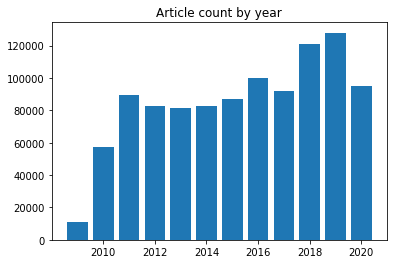

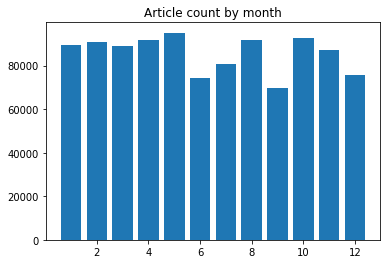

In [10]:

plt.bar(years, year_counts)
plt.title("Article count by year")
plt.show()


plt.bar(months, month_counts)
plt.title("Article count by month")
plt.show()

In [19]:
curr_year = 2010
curr_month = 1

config_data = []
path = './data/models/stemming/configurations.csv'
with open(str(path), encoding='utf-8') as csv_file:
    #date,no. sentiment words,alpha plus,alpha_minus,kappa,lambda,normalised error
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_no = 0
    for row in csv_reader:

        if line_no > 0:
            config_data.append([row[0],row[1],round(float(row[2]),4),round(float(row[3]),4),row[4],row[5],round(float(row[6]),2),row[6]])
        line_no +=  1
index = 0

while(index < len(config_data)):
    #SELECT ARTICLES
    val_date_start = datetime(curr_year+2,curr_month,1,0,0,0,0)
    val_date_end = datetime(curr_year+3,curr_month,1,0,0,0,0)
    curr_date = datetime(curr_year, curr_month, 1,0,0,0,0,pytz.UTC)
    val_date = datetime(curr_year + 2, curr_month, 1,0,0,0,0,pytz.UTC)
    val_end = datetime(curr_year + 3, curr_month, 1,0,0,0,0,pytz.UTC)
    # training_arts   = [a for a in article_list if (a['date'] >= curr_date and a['date'] < val_date)]
    validation_arts = [a for a in article_list if (a['date'] >= val_date and a['date'] < val_end)]
    config_data[index][7]  = round(float(config_data[index][7])/len(validation_arts),5)

    curr_month += 4
    if (curr_month > 12):
        curr_month = 1
        curr_year += 1
    index += 1

for row in config_data:
    print(str(row[0]) + ' & '  + str(row[1]) + ' & '  + str(row[2]) + ' & '  + str(row[3]) + ' & '  + str(row[4]) + ' & '  +str(row[5]) + ' & '  +str(row[6]) + ' & '  +str(row[7]) + '\\\\')

2010-1-1 & 100 & 0.0529 & 0.0487 & 92 & 5 & 20402.2 & 0.24727\\
2010-5-1 & 100 & 0.0405 & 0.0384 & 94 & 5 & 20714.66 & 0.24926\\
2010-9-1 & 25 & 0.1116 & 0.1043 & 92 & 5 & 20426.81 & 0.24675\\
2011-1-1 & 25 & 0.1023 & 0.1064 & 92 & 1 & 19963.67 & 0.24574\\
2011-5-1 & 50 & 0.1002 & 0.0921 & 90 & 5 & 19075.08 & 0.24598\\
2011-9-1 & 100 & 0.0425 & 0.0404 & 94 & 5 & 19255.78 & 0.24653\\
2012-1-1 & 100 & 0.0754 & 0.0744 & 88 & 5 & 20474.7 & 0.24744\\
2012-5-1 & 100 & 0.051 & 0.0489 & 92 & 10 & 21839.81 & 0.24961\\
2012-9-1 & 100 & 0.0536 & 0.0473 & 92 & 10 & 22243.55 & 0.24931\\
2013-1-1 & 50 & 0.0536 & 0.0672 & 94 & 5 & 21546.5 & 0.24702\\
2013-5-1 & 100 & 0.084 & 0.0913 & 86 & 5 & 22095.56 & 0.24552\\
2013-9-1 & 100 & 0.0688 & 0.076 & 88 & 10 & 23415.73 & 0.24885\\
2014-1-1 & 100 & 0.0395 & 0.0375 & 94 & 5 & 24819.11 & 0.24818\\
2014-5-1 & 100 & 0.0823 & 0.0954 & 86 & 5 & 24060.98 & 0.24652\\
2014-9-1 & 100 & 0.0392 & 0.0412 & 94 & 5 & 23536.73 & 0.24904\\
2015-1-1 & 100 & 0.0778 & 0.0898

Now let's look at the actual word data we pulled. We'll load it in wordcloud form, with the top 50 words of each sentiment represented by the average tone over all 19 trials.

upgrade & 0.016794951772062017 & 19 & 0 & 0
high & 0.010033554431779333 & 19 & 0 & 0
gainer & 0.013524412572822343 & 19 & 0 & 0
mover & 0.0075260843535126945 & 19 & 0 & 0
rais & 0.011851335286498023 & 18 & 0 & 0
repurchase & 0.000298333830307604 & 17 & 0 & 0
volume & 0.002742481034610761 & 16 & 0 & 0
rumor & 0.0007800938360581412 & 16 & 0 & 0
author & 6.813530302230894e-05 & 16 & 0 & 0
outperform & 0.0028570636749356837 & 15 & 0 & 0
higher & 0.006567234447939277 & 15 & 0 & 0
solid & 0.00043224022008646145 & 15 & 0 & 0
spike & 0.0021885802468981394 & 15 & 0 & 0
green & 0.0007113377382261724 & 14 & 0 & 0
buy & 0.008343607042205064 & 14 & 0 & 0
strong & 0.0005446015638093819 & 13 & 0 & 0
soar & 0.001171020355831584 & 13 & 0 & 0
overweight & 0.0016754338272568956 & 13 & 0 & 0
lift & 0.0006586259437203682 & 12 & 0 & 0
jump & 0.0008559254623020766 & 11 & 0 & 0
mention & 9.679605226212384e-05 & 11 & 0 & 0
strength & 0.0001468968678047511 & 11 & 0 & 0
special & 0.00015433463272212857 & 11 & 0 

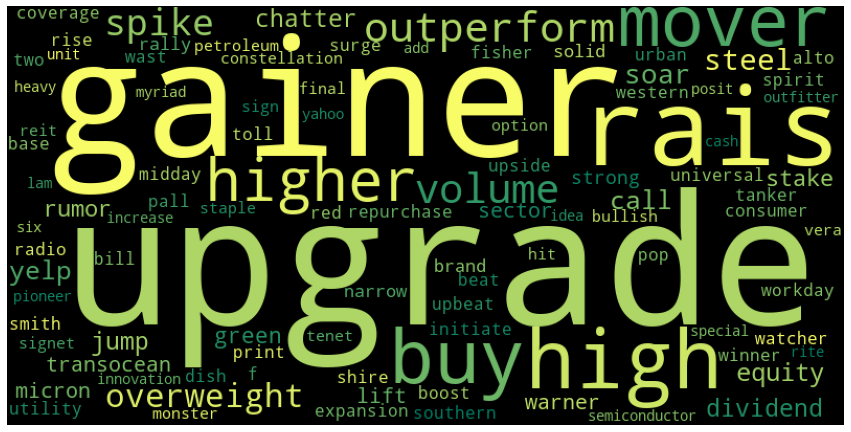

Top 100 sentiment negative words
[('downgrade', -0.023946011635140485), ('loser', -0.016850640304565363), ('lower', -0.016773040274824097), ('low', -0.0052906587357928045), ('fall', -0.0043448031444780506), ('neutral', -0.0033266020271109933), ('cut', -0.0030349015078132784), ('worst', -0.0029479077902279526)]


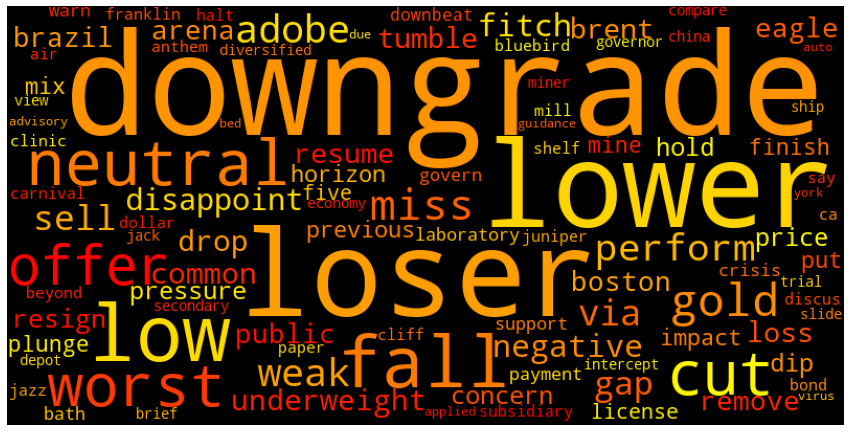

In [7]:

def get_top_words(data, n=2, order=False, reverse=True):
    """Get top n words by tone. 

    Returns a dictionary or an `OrderedDict` if `order` is true.
    """ 
    top = sorted(data.items(), key=lambda x: x[1][''], reverse=reverse)[:n]
    if order:
        return OrderedDict(top)
    return dict(top)

pathlist = Path('./data/models/stemming/word-lists/').rglob('*.csv')
word_list_tone = {}
word_list_count = {}
for path in pathlist:
    with open(str(path), encoding='utf-8') as csv_file:
        line = 0
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if line > 0:
                if (row[0] in word_list_tone):
                    word_list_tone[row[0]] += (float(row[1]) - float(row[2]))/2
                    word_list_count[row[0]] += 1
                else:
                    word_list_tone[row[0]] = (float(row[1]) - float(row[2]))/2
                    word_list_count[row[0]] = 1
            line += 1

word_list_count = {k: v for k, v in sorted(word_list_count.items(), reverse = True, key=lambda item: item[1])}
word_list_tone = {k: v for k, v in sorted(word_list_tone.items(), key=lambda item: item[1])}
for w in word_list_tone:
    word_list_tone[w] /= 19
# print(word_list_count)

high_word_counts    = [w for w in word_list_count if word_list_count[w] > 14]
# for w in high_word_counts:
#     print(w, word_list_tone[w], word_list_count[w])
pos_word_list_count = [w for w in word_list_count if word_list_tone[w] > 0][:50]
neg_word_list_count = [w for w in word_list_count if word_list_tone[w] < 0][:50]
for w in pos_word_list_count:
    # in_lm = 0
    # in_h4 = 0
    # if w in positive_words_lm:
    #     in_lm = 1
    # if w in positive_words_h4:
    #     in_h4 = 1
    print(w + " & " + str(word_list_tone[w]) + " & " + str(word_list_count[w]) + " & " + str(in_lm) + " & " + str(in_h4))
for w in neg_word_list_count:
    print(w + " & " + str(word_list_tone[w]) + " & " + str(word_list_count[w]))

print("Top 100 sentiment positive words")
# pos_words = dict(sorted(word_list_tone.items(), key = itemgetter(1), reverse = True)[:100])
pos_words = dict(sorted(word_list_tone.items(), key = itemgetter(1), reverse = True)[:100])
print(sorted(word_list_tone.items(), key = itemgetter(1), reverse = True)[:8])
pos_words = {w: pos_words[w] for w in pos_words if pos_words[w] > 0}
wordcloud = WordCloud(width=800, height=400,colormap='summer', collocations=True,prefer_horizontal=1, background_color='black')
wordcloud.generate_from_frequencies(frequencies = pos_words)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("Top 100 sentiment negative words")
#pos_words = dict(sorted(word_list_tone.items(), key = itemgetter(1), reverse = True)[:100])
neg_words = dict(sorted(word_list_tone.items(), key = itemgetter(1), reverse = False)[:100])
print(sorted(word_list_tone.items(), key = itemgetter(1), reverse = False)[:8])
neg_words = {w: neg_words[w] for w in neg_words if neg_words[w] < 0}
for w in neg_words:
    neg_words[w] = abs(neg_words[w])
# wordcloud = WordCloud(background_color='white', colormap='forest',prefer_horizontal=1)
wordcloud = WordCloud(width=800, height=400,colormap='autumn', collocations=True,prefer_horizontal=1, background_color='black', max_words=100)
wordcloud.generate_from_frequencies(frequencies = neg_words)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Out of sample Modelling
Ok so we have trained the model and visualised the data. Let's now build some portfolios from the out of sample data and compare the success of the model against some other popular dictionaries.

We will construct the sentiment score for these articles by aggregating counts of words listed in their positive sentiment dictionary (weighted tf-idf by LM)  and subtracting weighted counts of words in their negative dictionaries. For our SESTM, we average scores from multiple articles for the same firm in the same day.

What I think they mean (and this might be wrong) is that they will take the best 50 sentiment stocks and long them, and vice versa for the 50 words sentiment stocks for that say (short them). At the start of the next trading day, they 'liquidate' the stocks, and evaluate whether they made money or not, and then this is stored. This is done for both lexicon methods.

There are a few strategies that will be used to evaluate the methods:
- Sharpe ratio, which compares the success over the volatility of the stocks
- Potential Granger causality to prove that the headlines ARE actually the cause and it's not a fluke

## Fama-French models
The Fama-French three-factor model is a statistical model that describes stock returns. They explain phenomena using a small number of underlying causes or factors, and looks like this:
$$R_a = R_f + \beta_1(R_m - R_f)+ \beta_2 \cdot SMB + \beta_3 \cdot HML + \alpha$$
where:
- $R_a$: expected return on asset
- $R_f$: Risk free rate
- $\beta_{1,2,3}$: Factor coefficient
- $R_m - R_f$: Market risk premium
- $SMB$: (small minus big): Excess returns of small cap over large cap
- $HML$: (high minus low): Excess returns of value stocks over growth stocks
- $\alpha$: intercept




## Pull stock data

In [ ]:
# Collect out of sample articles
oos_start_year = 2018
oos_start_month = 5
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0,pytz.UTC)
oos_arts   = [a for a in article_list if (a['date'] >= start_date)]

# collect stock info
list_tickers = [a['ticker'] for a in oos_arts]
list_tickers = list(dict.fromkeys(list_tickers))
stock_data = {}
failed_stocks = []
print('pulling stocks...')
# data = yf.download(tickers = list_tickers, end=str(end_date.date()), start=str(start_date.date()), progress=True)
curr_index = 0
TOTAL_TICKERS = len(list_tickers)
for t in list_tickers:
    arts_ticker = [a['date'] for a in article_list if a['ticker'] == t]
    # print(type(arts_ticker[0]))
    end_date_stock_data = max(arts_ticker) + dt.timedelta(days=5)
    start_date_stock_data = min(arts_ticker) - dt.timedelta(days=5)
    try:
        data = yf.download(tickers = t, end=str(end_date_stock_data.date()), start=str(start_date_stock_data.date()), progress=False, show_errors=False)
        if len(data > 0):
            stock_data[t] = data
        else:
            failed_stocks.append(t)
    except:
        failed_stocks.append(t)
    sys.stdout.write('\r')
    j = (curr_index + 1) / TOTAL_TICKERS
    sys.stdout.write("[%-20s] %d%% %d out of %d (%d)" % ('='*int(20*j), 100*j, curr_index, TOTAL_TICKERS, len(failed_stocks)))
    sys.stdout.flush()
    curr_index += 1

In [ ]:
# save stocks to file
for s in stock_data:
    with open('./processed-data-raw/' + s + '.json', 'w') as json_file:
        json.dump(stock_data[s].to_json(), json_file)

In [24]:
# load stocks from file

ticker_path = './processed-data-raw/'
# recreate list of stock information
pathlist = Path(ticker_path).rglob('*.json')
stock_data = {}
i = 0
for path in pathlist:
    with open(str(path)) as json_file:
        sys.stdout.write('\r')
        sys.stdout.write("pulling file no %d" % (i))
        sys.stdout.flush()#
        i += 1
        data = json.load(json_file)
        data = json.loads(data)
        datetime_dict = {}
        for line in data:
            datetime_line = {}
            for k in data[line]:
                # print(str(datetime.fromtimestamp(float(k)/1000.0)))
                datetime_line[str(datetime.fromtimestamp(float(k)/1000.0).date())] = data[line][k]
            datetime_dict[line] = datetime_line 
        stock_data[os.path.basename(str(path))[:-5]] = DataFrame.from_dict(datetime_dict)

pulling file no 2960

In [ ]:

oos_start_year = 2019
oos_start_month = 1
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0)
possible_dates = [datetime.strptime(d + ' 00:00:00+00:00', '%Y-%m-%d %H:%M:%S%z') for d in stock_data['A']['Open'].keys() if datetime.strptime(d, '%Y-%m-%d') > start_date]

## Equal weighted strategy

In [ ]:
oos_start_year = 2019
oos_start_month = 1
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0,pytz.UTC)
oos_arts   = [a for a in article_list if (a['date'] >= start_date)]
print(len(oos_arts))
curr_day = 1
LAM = 5

prev_days = 7
best_config_file = './data/models/stemming/word-lists/2013-5-1.csv'
sentiment_words = []
O = np.array([0,0])
with open(best_config_file, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0:
            sentiment_words.append(row[0])
            O = np.vstack((O,[row[1], row[2]]))
        line_count += 1
O = O[1:]
# for i in range(len(sentiment_words)):
#     print(sentiment_words[i] + ": " + str(O[i][0]) + "//" + str(O[i][1]))
for prev_days in range(-1,11):
    print('Prev days: ' + str(prev_days))
    # Collect out of sample articles

    trial_id = '2013-05-01-111-ew-day+' + str(prev_days)
    curr_month = oos_start_month
    curr_year = oos_start_year
    destination_directory = os.path.join('./data/out-of-sample/', trial_id)
    if not os.path.exists(destination_directory):
        os.mkdir(destination_directory)
        # os.mkdir(destination_directory, 'portfolios')
        os.mkdir(os.path.join(destination_directory,'portfolios'))
        os.mkdir(os.path.join(destination_directory,'portfolios/short'))
        # os.mkdir(destination_directory + '/portfolios/short')
        os.mkdir(os.path.join(destination_directory,'portfolios/long'))
        print('New folder ' + str(destination_directory) + ' created')


    list_dates = [a['date'] for a in oos_arts]
    end_date = max(list_dates)
    curr_date = datetime(curr_year, curr_month, curr_day, 9, 0,0,0,pytz.UTC)
    curr_date = possible_dates[min(prev_days,0)]
    prev_date = curr_date - dt.timedelta(days=1)
    prev_top = {}
    prev_bot = {}
    output_file = os.path.join(destination_directory, 'estimations.csv')

    #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
    #empty file
    with open(output_file, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str('DATE'), str('long value'), str('EARNING LONG'), str('short value'), str('EARNING SHORT'), str('NUMBER LONG'), str('NUMBER SHORT'), str('TOTAL FIRMS WITH ARTS'), str('HEADLINES WITH SENTIMENT WORDS')])

    portfolio_value = 10000
    for curr_t in range(max(prev_days,0), len(possible_dates) + min(prev_days,0)-1):
        curr_date = possible_dates[curr_t]
        # calculate new date and pull new articles
        article_date = possible_dates[curr_t - prev_days]
        article_date_1 = possible_dates[(curr_t - prev_days)+1]
        # article_date_1 = article_date + dt.timedelta(days=1)
        #pull articles from previous day to work out what stocks to buy today
        daily_arts = [a for a in oos_arts if (article_date < a['date']) and (article_date_1 > a['date'])]
        long_correct = 0
        short_correct = 0
        # total_earnings_long = 0
        # total_earnings_short = 0
        investment_long = 0
        investment_short = 0
        earning_long = 0
        earning_short = 0
        if (len(daily_arts) > 0 and not stock_data['A']['Open'].get(str(curr_date.date()),'E') == 'E'):
            #calculate how many guesses were right from yesterday
            if len(prev_bot) > 0:
                # with open(os.path.join(destination_directory, 'portfolios/long/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                #     csvwriter = csv.writer(csv_file)
                total_sum_top = sum([prev_top[t] for t in prev_top])
                for tick in prev_top:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        investment = portfolio_value*(1/len(prev_top))
                        # investment = portfolio_value*(prev_top[tick]/total_sum_top)
                        earning_long += (testing_value)*(investment/prev_top[tick])
                        investment_long += investment
                        # total_earnings_long += (testing_value - prev_top[tick]) * (1/len(prev_top))
                        # csvwriter.writerow([str(tick), prev_top[tick], testing_value])
                # with open(os.path.join(destination_directory, 'portfolios/short/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                #     csvwriter = csv.writer(csv_file)
                total_sum_bot = sum([prev_bot[t] for t in prev_bot])
                for tick in prev_bot:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        # csvwriter.writerow([str(tick), prev_bot[tick], testing_value])
                        investment = portfolio_value*(1/len(prev_bot))
                        # investment = portfolio_value*(prev_bot[tick]/total_sum_bot)
                        earning_short += testing_value*(investment/prev_bot[tick])
                        investment_short += investment
                        # total_earnings_short +=  (prev_bot[tick] - testing_value)*(1/len(prev_bot))

            #preprocess arts
            oos_d = []
            for oos_a in daily_arts:
                oos_bow = text_to_bow(oos_a['headline'])
                oos_d.append(oos_bow)
            
            #generate list of estimates for arts
            article_estimates = []
            for oos_index in range(len(oos_d)):
                est_p = 0.5
                oos_bow = oos_d[oos_index]
                testing_s = sum(oos_bow.get(w,0) for w in sentiment_words)
                if (testing_s > 0):
                    est_p = fminbound(equation_to_solve, 0, 1, (O,oos_bow, sentiment_words,testing_s,LAM))
                article_estimates.append(est_p)

            #allocate estimates for each stock
            tickers = list(set([a['ticker'] for a in oos_arts]))
            ticker_sentiment = {}
            for t in tickers:
                ticker_arts = [index for (index,a) in enumerate(daily_arts) if a['ticker'] == t]
                if(len(ticker_arts) > 0):
                    ticker_sentiment[t] = sum([article_estimates[ta] for ta in ticker_arts])/len(ticker_arts)
                #
                # else:
                #NOTE!: I chose not to add it so it makes calculating top/bot 50 easier
                #     ticker_sentiment[t] = 0.5
            
            #allocate top 50 of each (if there are 50)
            ticker_with_art = len(ticker_sentiment)
            ticker_sentiment = {key:val for key, val in ticker_sentiment.items() if val != 0.5}
            ticker_with_sent = len(ticker_sentiment)
            # ensure the portfolio can't buy the same stock for both long and short (because that's SILLY)
            top_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = True)[:50])
            bot_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = False)[:50])
            top_50_tickers = {key:val for key, val in top_50_tickers.items() if val > 0.5}
            bot_50_tickers = {key:val for key, val in bot_50_tickers.items() if val < 0.5}
            print(str(curr_date) + "//" + str(bot_50_tickers))
            top_50 = {}
            bot_50 = {}
            diff_stocks = 0
            for tick in top_50_tickers:
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        top_50[tick] = testing_value
                        if not tick in prev_top:
                            diff_stocks += 1
            for tick in bot_50_tickers:
                # testing_value = stock_data.get(tick,'E')
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        bot_50[tick] = testing_value
                        if not tick in prev_bot:
                            diff_stocks += 1

            #print results to file
            #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
            with open(output_file, 'a', newline='') as csv_file:
                csvwriter = csv.writer(csv_file)
                csvwriter.writerow([str((curr_date).date()), str(investment_long), str(earning_long), str(investment_short), str(earning_short), str(len(prev_top)), str(len(prev_bot)), str(ticker_with_art), str(ticker_with_sent)])

            #reset for next iter
            prev_date = curr_date
            prev_top = top_50
            prev_bot = bot_50
        # else:
        #     print('Not a market day: ' + str(curr_date))

## Value weighted strat

In [ ]:
oos_start_year = 2019
oos_start_month = 1
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0,pytz.UTC)
oos_arts   = [a for a in article_list if (a['date'] >= start_date)]
print(len(oos_arts))
curr_day = 1
LAM = 5

prev_days = 7
best_config_file = './data/models/stemming/word-lists/2013-5-1.csv'
sentiment_words = []
O = np.array([0,0])
with open(best_config_file, encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0:
            sentiment_words.append(row[0])
            O = np.vstack((O,[row[1], row[2]]))
        line_count += 1
O = O[1:]
for i in range(len(sentiment_words)):
    print(sentiment_words[i] + ": " + str(O[i][0]) + "//" + str(O[i][1]))
for prev_days in range(-1,11):
    print('Prev days: ' + str(prev_days))
    # Collect out of sample articles

    trial_id = '2013-05-01-111-vw-day+' + str(prev_days)
    curr_month = oos_start_month
    curr_year = oos_start_year
    destination_directory = os.path.join('./data/out-of-sample/', trial_id)
    if not os.path.exists(destination_directory):
        os.mkdir(destination_directory)
        # os.mkdir(destination_directory, 'portfolios')
        os.mkdir(os.path.join(destination_directory,'portfolios'))
        os.mkdir(os.path.join(destination_directory,'portfolios/short'))
        # os.mkdir(destination_directory + '/portfolios/short')
        os.mkdir(os.path.join(destination_directory,'portfolios/long'))
        print('New folder ' + str(destination_directory) + ' created')


    list_dates = [a['date'] for a in oos_arts]
    end_date = max(list_dates)
    curr_date = datetime(curr_year, curr_month, curr_day, 9, 0,0,0,pytz.UTC)
    curr_date = possible_dates[min(prev_days,0)]
    prev_date = curr_date - dt.timedelta(days=1)
    prev_top = {}
    prev_bot = {}
    output_file = os.path.join(destination_directory, 'estimations.csv')

    #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
    #empty file
    with open(output_file, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str('DATE'), str('long value'), str('EARNING LONG'), str('short value'), str('EARNING SHORT'), str('NUMBER LONG'), str('NUMBER SHORT'), str('TOTAL FIRMS WITH ARTS'), str('HEADLINES WITH SENTIMENT WORDS')])

    portfolio_value = 10000
    for curr_t in range(max(prev_days,0), len(possible_dates) + min(prev_days,0)-1):
        curr_date = possible_dates[curr_t]
        # calculate new date and pull new articles
        article_date = possible_dates[curr_t - prev_days]
        article_date_1 = possible_dates[(curr_t - prev_days)+1]
        # article_date_1 = article_date + dt.timedelta(days=1)
        #pull articles from previous day to work out what stocks to buy today
        daily_arts = [a for a in oos_arts if (article_date < a['date']) and (article_date_1 > a['date'])]
        long_correct = 0
        short_correct = 0
        # total_earnings_long = 0
        # total_earnings_short = 0
        investment_long = 0
        investment_short = 0
        earning_long = 0
        earning_short = 0
        if (len(daily_arts) > 0 and not stock_data['A']['Open'].get(str(curr_date.date()),'E') == 'E'):
            #calculate how many guesses were right from yesterday
            if len(prev_bot) > 0:
                # with open(os.path.join(destination_directory, 'portfolios/long/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                #     csvwriter = csv.writer(csv_file)
                total_sum_top = sum([prev_top[t] for t in prev_top])
                for tick in prev_top:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        # investment = portfolio_value*(1/len(prev_top))
                        investment = portfolio_value*(prev_top[tick]/total_sum_top)
                        earning_long += (testing_value)*(investment/prev_top[tick])
                        investment_long += investment
                        # total_earnings_long += (testing_value - prev_top[tick]) * (1/len(prev_top))
                        # csvwriter.writerow([str(tick), prev_top[tick], testing_value])
                # with open(os.path.join(destination_directory, 'portfolios/short/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                #     csvwriter = csv.writer(csv_file)
                total_sum_bot = sum([prev_bot[t] for t in prev_bot])
                for tick in prev_bot:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        # csvwriter.writerow([str(tick), prev_bot[tick], testing_value])
                        # investment = portfolio_value*(1/len(prev_bot))
                        investment = portfolio_value*(prev_bot[tick]/total_sum_bot)
                        earning_short += testing_value*(investment/prev_bot[tick])
                        investment_short += investment
                        # total_earnings_short +=  (prev_bot[tick] - testing_value)*(1/len(prev_bot))

            #preprocess arts
            oos_d = []
            for oos_a in daily_arts:
                oos_bow = text_to_bow(oos_a['headline'])
                oos_d.append(oos_bow)
            
            #generate list of estimates for arts
            article_estimates = []
            for oos_index in range(len(oos_d)):
                est_p = 0.5
                oos_bow = oos_d[oos_index]
                testing_s = sum(oos_bow.get(w,0) for w in sentiment_words)
                if (testing_s > 0):
                    est_p = fminbound(equation_to_solve, 0, 1, (O,oos_bow, sentiment_words,testing_s,LAM))
                article_estimates.append(est_p)

            #allocate estimates for each stock
            tickers = list(set([a['ticker'] for a in oos_arts]))
            ticker_sentiment = {}
            for t in tickers:
                ticker_arts = [index for (index,a) in enumerate(daily_arts) if a['ticker'] == t]
                if(len(ticker_arts) > 0):
                    ticker_sentiment[t] = sum([article_estimates[ta] for ta in ticker_arts])/len(ticker_arts)
                #
                # else:
                #NOTE!: I chose not to add it so it makes calculating top/bot 50 easier
                #     ticker_sentiment[t] = 0.5
            
            #allocate top 50 of each (if there are 50)
            ticker_with_art = len(ticker_sentiment)
            ticker_sentiment = {key:val for key, val in ticker_sentiment.items() if val != 0.5}
            ticker_with_sent = len(ticker_sentiment)
            # ensure the portfolio can't buy the same stock for both long and short (because that's SILLY)
            top_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = True)[:50])
            bot_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = False)[:50])
            top_50_tickers = {key:val for key, val in top_50_tickers.items() if val > 0.5}
            bot_50_tickers = {key:val for key, val in bot_50_tickers.items() if val < 0.5}
            top_50 = {}
            bot_50 = {}
            diff_stocks = 0
            for tick in top_50_tickers:
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        top_50[tick] = testing_value
                        if not tick in prev_top:
                            diff_stocks += 1
            for tick in bot_50_tickers:
                # testing_value = stock_data.get(tick,'E')
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        bot_50[tick] = testing_value
                        if not tick in prev_bot:
                            diff_stocks += 1

            #print results to file
            #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
            with open(output_file, 'a', newline='') as csv_file:
                csvwriter = csv.writer(csv_file)
                csvwriter.writerow([str((curr_date).date()), str(investment_long), str(earning_long), str(investment_short), str(earning_short), str(len(prev_top)), str(len(prev_bot)), str(ticker_with_art), str(ticker_with_sent)])

            #reset for next iter
            prev_date = curr_date
            prev_top = top_50
            prev_bot = bot_50
        # else:
        #     print('Not a market day: ' + str(curr_date))

223227
neutral: 0.04054655681049474//0.0545572767033919
upgrade: 0.1310445364504674//0.06317542624372584
buy: 0.15366643292008184//0.0903824702240931
jack: 0.00046953917047534076//0.0036049715506665503
miss: 0.008147923519011366//0.011624202733325917
raise: 0.1311569804135689//0.08928001725924035
replace: 0.0032544268393949146//0.0031521201237085057
lower: 0.051415606930454584//0.11068301488689863
bill: 0.00479211327657567//0.0024720355663908713
volume: 0.03025365821904564//0.006399108159063686
overweight: 0.021873507753379755//0.011842010687189831
downgrade: 0.0779550473042124//0.15946552448870574
solid: 0.005971447367127025//0.0035076615037003584
mad: 0.002562528066326622//0.0019405258584481086
mention: 0.00259432369289356//0.0022470251286228708
cut: 0.0053319560964314085//0.02069622775843526
resume: 0.012023180115455013//0.015903459813639817
outperform: 0.04935946705825287//0.03311167326813328
worst: 0.0016184562403284682//0.020983695035426072
public: 0.006860691600220165//0.0077136

Ok, so now let's evaluate this data and see what it gives us. Firstly, we want to see the Sharpe ratio of the portfolios, so let's look at the long and the short legs and calculate a Sharpe ratio for this.

In [45]:
import statistics
# process this data
evaluate_id = 'pass-2013-05-01-ew'
evaluate_file = os.path.join('./data/out-of-sample/', evaluate_id)
with open(os.path.join(evaluate_file,'estimations.csv')) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    long_returns = []
    short_returns = []
    long_earnings = []
    short_earnings = []
    ls_earnings = []
    ls_returns = []
    for row in csv_reader:
        if line_count > 1:
            long_returns.append(int(row[1]) - int(int(row[5]) - int(row[1])))
            short_returns.append(int(row[2]) - int(int(row[6]) - int(row[2])))
            long_earnings.append(float(row[3]))
            short_earnings.append(float(row[4]))
            ls_earnings.append(float(row[3]) + float(row[4]))
            ls_returns.append(int(row[1]) - int(int(row[5]) - int(row[1])) + int(row[2]) - int(int(row[6]) - int(row[2])))
        line_count += 1

# print(long_returns)
# print(short_returns)
print('Average correct for long: ' + str(sum(long_returns)/len(long_returns)))
print('Average correct for short: ' + str(sum(short_returns)/len(short_returns)))
print('Average correct for ls: ' + str(sum(ls_returns)/len(ls_returns)))
print('='*(30))
print('Average earnings for long: ' + str(sum(long_earnings)/len(long_earnings)))
print('Average earnings for short: ' + str(sum(short_earnings)/len(short_earnings)))
print('Average earnings for ls: ' + str(sum(ls_earnings)/len(ls_earnings)))
print('='*(30))
risk_free_rate = 0.164
print('Sharpe ratio long = ' + (str((((sum(long_earnings)/len(long_earnings)) - risk_free_rate)/statistics.stdev(long_earnings))*math.sqrt(252))))
print('Sharpe ratio short = ' + (str((((sum(short_earnings)/len(short_earnings)) - risk_free_rate)/statistics.stdev(short_earnings))*math.sqrt(252))))
print('Sharpe ratio ls = ' + (str((((sum(ls_earnings)/len(ls_earnings)) - risk_free_rate)/statistics.stdev(ls_earnings))*math.sqrt(252))))


Average correct for long: 13.227146814404431
Average correct for short: 7.083102493074792
Average correct for ls: 20.310249307479225
Average earnings for long: 0.4161124336068474
Average earnings for short: 0.44237238866891415
Average earnings for ls: 0.8584848222757611
Sharpe ratio long = 0.8414083644828624
Sharpe ratio short = 3.6111039658374553
Sharpe ratio ls = 2.3582223356564405


## Using LM lexicon

In [21]:
#calc negative and positive word lists
positive_words_lm = {}
negative_words_lm = {}
with open('../external-csvs/LM-Dictionary-1993-2021.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0:
            if row[8] != str(0):
                positive_words_lm[str(row[0]).lower()] = 0
            if row[7] != str(0):
                negative_words_lm[str(row[0]).lower()] = 0
            # sentiment_score[row[0]] = {'neg': float(row[8]), 'pos': float(row[9])}
        line_count += 1

In [22]:

#calc negative and positive word lists
positive_words_h4 = {}
negative_words_h4 = {}
with open('../external-csvs/HIV-4.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # FORMAT: line#,headline,date,stock
    for row in csv_reader:
        if line_count > 0:
            if row[2] != "":
                positive_words_h4[str(row[0]).lower()] = 0
            if row[3] != "":
                negative_words_h4[str(row[0]).lower()] = 0
            # sentiment_score[row[0]] = {'neg': float(row[8]), 'pos': float(row[9])}
        line_count += 1

In [7]:
print(len(positive_words_lm))
print(len(negative_words_lm))
print(len(positive_words_h4))
print(len(negative_words_h4))

354
2355
1915
2291


In [42]:
# Collect out of sample articles
oos_start_year = 2019
oos_start_month = 1
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0,pytz.UTC)
oos_arts   = [a for a in article_list if (a['date'] >= start_date)]
print(len(oos_arts))
curr_day = 1
LAM = 5

for prev_days in range(-1,8):
    trial_id = 'LM-EW-day+' + str(prev_days)
    curr_month = oos_start_month
    curr_year = oos_start_year
    destination_directory = os.path.join('./data/out-of-sample/', trial_id)
    if not os.path.exists(destination_directory):
        os.mkdir(destination_directory)
        # os.mkdir(destination_directory, 'portfolios')
        os.mkdir(os.path.join(destination_directory,'portfolios'))
        os.mkdir(os.path.join(destination_directory,'portfolios/short'))
        # os.mkdir(destination_directory + '/portfolios/short')
        os.mkdir(os.path.join(destination_directory,'portfolios/long'))
        print('New folder ' + str(destination_directory) + ' created')


    # sentiment_words = []
    # sentiment_score = {}
    # with open('../external-csvs/LM-Dictionary-1993-2021.csv', encoding='utf-8') as csv_file:
    #     csv_reader = csv.reader(csv_file, delimiter=',')
    #     line_count = 0
    #     # FORMAT: line#,headline,date,stock
    #     for row in csv_reader:
    #         if line_count > 0:
    #             sentiment_score[row[0]] = {'neg': float(row[8]), 'pos': float(row[9])}
    #         line_count += 1
    list_dates = [a['date'] for a in oos_arts]
    end_date = max(list_dates)
    curr_date = datetime(curr_year, curr_month, curr_day, 9, 0,0,0,pytz.UTC)
    prev_date = curr_date - dt.timedelta(days=1)
    prev_top = {}
    prev_bot = {}
    output_file = os.path.join(destination_directory, 'estimations.csv')

    #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
    #empty file
    with open(output_file, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str('DATE'), str('EARNING LONG'), str('INVESTMENT LONG'), str('EARNING SHORT'), str('INVESTMENT SHORT'), str('NUMBER LONG'), str('NUMBER SHORT'), str('TURNOVER %'), str('TOTAL FIRMS WITH ARTS'), str('HEADLINES WITH SENTIMENT WORDS')])

    for curr_t in range(max(prev_days,0), len(possible_dates) + min(prev_days,0)-1):
        curr_date = possible_dates[curr_t]
        # calculate new date and pull new articles
        article_date = possible_dates[curr_t - prev_days]
        article_date_1 = possible_dates[(curr_t - prev_days)+1]
        # article_date_1 = article_date + dt.timedelta(days=1)
        #pull articles from previous day to work out what stocks to buy today
        daily_arts = [a for a in oos_arts if (article_date < a['date']) and (article_date_1 > a['date'])]
        # calculate tfidf for each day
        long_correct = 0
        short_correct = 0
        # total_earnings_long = 0
        # total_earnings_short = 0
        investment_long = 0
        investment_short = 0
        earning_long = 0
        earning_short = 0
        portfolio_value = 10000
        if (len(daily_arts) > 0 and not stock_data['A']['Open'].get(str(curr_date.date()),'E') == 'E'):
            #calculate how many guesses were right from yesterday
            if len(prev_bot) > 0:
                with open(os.path.join(destination_directory, 'portfolios/long/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                    csvwriter = csv.writer(csv_file)
                    for tick in prev_top:
                        testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                        if not testing_value == 'E':
                            investment = portfolio_value*(1/len(prev_top))
                            earning_long += (testing_value)*(investment/prev_top[tick])
                            investment_long += investment
                            # total_earnings_long += (testing_value - prev_top[tick]) * (1/len(prev_top))
                            csvwriter.writerow([str(tick), prev_top[tick], testing_value])
                            if (prev_top[tick] - testing_value <= 0):
                                long_correct += 1
                with open(os.path.join(destination_directory, 'portfolios/short/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                    csvwriter = csv.writer(csv_file)
                    for tick in prev_bot:
                        testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                        if not testing_value == 'E':
                            csvwriter.writerow([str(tick), prev_bot[tick], testing_value])
                            investment = portfolio_value*(1/len(prev_bot))
                            earning_short += testing_value*(investment/prev_bot[tick])
                            investment_short += investment
                            # total_earnings_short +=  (prev_bot[tick] - testing_value)*(1/len(prev_bot))
                            if (prev_bot[tick] - testing_value > 0):
                                short_correct += 1
                    #else what? Assume not correct? Assume correct? I have chosen to assume incorrect

            #preprocess arts
            oos_d = []
            for oos_a in daily_arts:
                oos_bow = text_to_bow(oos_a['headline'])
                oos_d.append(oos_bow)
            for w in positive_words:
                # tf = 
                idf = len(oos_d) / (1+(len([a for a in oos_d if w in a])))
                if idf > len(oos_d):
                    print(str(w) + " // " + str(idf))
                positive_words[w] = math.log(idf)
            # print(oos_d[0])
            # print('coverage' in oos_d[0])
            # print([a for a in oos_d if 'miss' in a])
            for w in negative_words:
                # tf = 
                idf = len(oos_d) / (1+(len([a for a in oos_d if w in a])))
                if idf > len(oos_d):
                    print(str(w) + " // " + str(idf))
                negative_words[w] = math.log(idf)
            
            #generate list of estimates for arts
            article_estimates = []
            for oos_index in range(len(oos_d)):
                est_p = 0
                oos_bow = oos_d[oos_index]
                for w in oos_bow:
                    # if w in positive_words or w in negative_words:
                    est_p += (positive_words.get(w,0)*math.log(1+oos_bow.get(w,0)) - negative_words.get(w,0)*math.log(1+oos_bow.get(w,0)))
                article_estimates.append(est_p)

            #allocate estimates for each stock
            tickers = list(set([a['ticker'] for a in oos_arts]))
            ticker_sentiment = {}
            for t in tickers:
                ticker_arts = [index for (index,a) in enumerate(daily_arts) if a['ticker'] == t]
                if(len(ticker_arts) > 0):
                    ticker_sentiment[t] = sum([article_estimates[ta] for ta in ticker_arts])/len(ticker_arts)
                #
                # else:
                #NOTE!: I chose not to add it so it makes calculating top/bot 50 easier
                #     ticker_sentiment[t] = 0.5
            
            #allocate top 50 of each (if there are 50)
            ticker_with_art = len(ticker_sentiment)
            ticker_sentiment = {key:val for key, val in ticker_sentiment.items() if val != 0.5}
            ticker_with_sent = len(ticker_sentiment)
            top_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = True)[:50])
            bot_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = False)[:50])
            top_50_tickers = {key:val for key, val in top_50_tickers.items()}
            bot_50_tickers = {key:val for key, val in bot_50_tickers.items()}
            top_50 = {}
            bot_50 = {}
            diff_stocks = 0
            for tick in top_50_tickers:
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        top_50[tick] = testing_value
                        if not tick in prev_top:
                            diff_stocks += 1
            for tick in bot_50_tickers:
                # testing_value = stock_data.get(tick,'E')
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        bot_50[tick] = testing_value
                        if not tick in prev_bot:
                            diff_stocks += 1
            if (len(prev_top) > 0):
                diff_stocks /= (len(prev_bot) + len(prev_top))
            else:
                diff_stocks = 0

            #print results to file
            #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
            with open(output_file, 'a', newline='') as csv_file:
                csvwriter = csv.writer(csv_file)
                csvwriter.writerow([str((prev_date).date()), str(earning_long), str(investment_long), str(earning_short), str(investment_short), str(len(prev_top)), str(len(prev_bot)), str(diff_stocks), str(ticker_with_art), str(ticker_with_sent)])

            #reset for next iter
            prev_date = curr_date
            prev_top = top_50
            prev_bot = bot_50
        # else:
        #     print('Not a market day: ' + str(curr_date))
        curr_date = curr_date + dt.timedelta(days=1)

223227


In [11]:

# Collect out of sample articles
oos_start_year = 2019
oos_start_month = 1
# oos_start_year = 2020
# oos_start_month = 5
total_outgoings = 0
total_earnings = 0
start_date = datetime(oos_start_year, oos_start_month, 1, 0,0,0,0,pytz.UTC)
oos_arts   = [a for a in article_list if (a['date'] >= start_date)]
print(len(oos_arts))
curr_day = 1
LAM = 5

for prev_days in range(-1,8):
    trial_id = 'H4-EW-day+' + str(prev_days)
    curr_month = oos_start_month
    curr_year = oos_start_year
    destination_directory = os.path.join('./data/out-of-sample/', trial_id)
    if not os.path.exists(destination_directory):
        os.mkdir(destination_directory)
        # os.mkdir(destination_directory, 'portfolios')
        os.mkdir(os.path.join(destination_directory,'portfolios'))
        os.mkdir(os.path.join(destination_directory,'portfolios/short'))
        # os.mkdir(destination_directory + '/portfolios/short')
        os.mkdir(os.path.join(destination_directory,'portfolios/long'))
        print('New folder ' + str(destination_directory) + ' created')


    # sentiment_words = []
    # sentiment_score = {}
    # with open('../external-csvs/LM-Dictionary-1993-2021.csv', encoding='utf-8') as csv_file:
    #     csv_reader = csv.reader(csv_file, delimiter=',')
    #     line_count = 0
    #     # FORMAT: line#,headline,date,stock
    #     for row in csv_reader:
    #         if line_count > 0:
    #             sentiment_score[row[0]] = {'neg': float(row[8]), 'pos': float(row[9])}
    #         line_count += 1
    list_dates = [a['date'] for a in oos_arts]
    end_date = max(list_dates)
    curr_date = datetime(curr_year, curr_month, curr_day, 9, 0,0,0,pytz.UTC)
    prev_date = curr_date - dt.timedelta(days=1)
    prev_top = {}
    prev_bot = {}
    output_file = os.path.join(destination_directory, 'estimations.csv')

    #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
    #empty file
    with open(output_file, 'w', newline='') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow([str('DATE'), str('EARNING LONG'), str('INVESTMENT LONG'), str('EARNING SHORT'), str('INVESTMENT SHORT'), str('NUMBER LONG'), str('NUMBER SHORT'), str('TURNOVER %'), str('TOTAL FIRMS WITH ARTS'), str('HEADLINES WITH SENTIMENT WORDS')])

    for curr_t in range(max(prev_days,0), len(possible_dates) + min(prev_days,0)-1):
        curr_date = possible_dates[curr_t]
        # calculate new date and pull new articles
        article_date = possible_dates[curr_t - prev_days]
        article_date_1 = possible_dates[(curr_t - prev_days)+1]
        # article_date_1 = article_date + dt.timedelta(days=1)
        #pull articles from previous day to work out what stocks to buy today
        daily_arts = [a for a in oos_arts if (article_date < a['date']) and (article_date_1 > a['date'])]
        # calculate tfidf for each day
        long_correct = 0
        short_correct = 0
        # total_earnings_long = 0
        # total_earnings_short = 0
        investment_long = 0
        investment_short = 0
        earning_long = 0
        earning_short = 0
        portfolio_value = 10000
        if (len(daily_arts) > 0 and not stock_data['A']['Open'].get(str(curr_date.date()),'E') == 'E'):
            #calculate how many guesses were right from yesterday
            if len(prev_bot) > 0:
                with open(os.path.join(destination_directory, 'portfolios/long/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                    csvwriter = csv.writer(csv_file)
                    for tick in prev_top:
                        testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                        if not testing_value == 'E':
                            investment = portfolio_value*(1/len(prev_top))
                            earning_long += (testing_value)*(investment/prev_top[tick])
                            investment_long += investment
                            # total_earnings_long += (testing_value - prev_top[tick]) * (1/len(prev_top))
                            csvwriter.writerow([str(tick), prev_top[tick], testing_value])
                            if (prev_top[tick] - testing_value <= 0):
                                long_correct += 1
                with open(os.path.join(destination_directory, 'portfolios/short/' + str(prev_date.date()) + '.csv'), 'w', newline='') as csv_file:
                    csvwriter = csv.writer(csv_file)
                    for tick in prev_bot:
                        testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                        if not testing_value == 'E':
                            csvwriter.writerow([str(tick), prev_bot[tick], testing_value])
                            investment = portfolio_value*(1/len(prev_bot))
                            earning_short += testing_value*(investment/prev_bot[tick])
                            investment_short += investment
                            # total_earnings_short +=  (prev_bot[tick] - testing_value)*(1/len(prev_bot))
                            if (prev_bot[tick] - testing_value > 0):
                                short_correct += 1
                    #else what? Assume not correct? Assume correct? I have chosen to assume incorrect

            #preprocess arts
            oos_d = []
            for oos_a in daily_arts:
                oos_bow = text_to_bow(oos_a['headline'])
                oos_d.append(oos_bow)
            for w in positive_words_h4:
                # tf = 
                idf = len(oos_d) / (1+(len([a for a in oos_d if w in a])))
                if idf > len(oos_d):
                    print(str(w) + " // " + str(idf))
                positive_words_h4[w] = math.log(idf)
            # print(oos_d[0])
            # print('coverage' in oos_d[0])
            # print([a for a in oos_d if 'miss' in a])
            for w in negative_words_h4:
                # tf = 
                idf = len(oos_d) / (1+(len([a for a in oos_d if w in a])))
                if idf > len(oos_d):
                    print(str(w) + " // " + str(idf))
                negative_words_h4[w] = math.log(idf)
            
            #generate list of estimates for arts
            article_estimates = []
            for oos_index in range(len(oos_d)):
                est_p = 0
                oos_bow = oos_d[oos_index]
                for w in oos_bow:
                    # if w in positive_words or w in negative_words:
                    est_p += (positive_words_h4.get(w,0)*math.log(1+oos_bow.get(w,0)) - negative_words_h4.get(w,0)*math.log(1+oos_bow.get(w,0)))
                article_estimates.append(est_p)

            #allocate estimates for each stock
            tickers = list(set([a['ticker'] for a in oos_arts]))
            ticker_sentiment = {}
            for t in tickers:
                ticker_arts = [index for (index,a) in enumerate(daily_arts) if a['ticker'] == t]
                if(len(ticker_arts) > 0):
                    ticker_sentiment[t] = sum([article_estimates[ta] for ta in ticker_arts])/len(ticker_arts)
                #
                # else:
                #NOTE!: I chose not to add it so it makes calculating top/bot 50 easier
                #     ticker_sentiment[t] = 0.5
            
            #allocate top 50 of each (if there are 50)
            ticker_with_art = len(ticker_sentiment)
            ticker_sentiment = {key:val for key, val in ticker_sentiment.items() if val != 0.5}
            ticker_with_sent = len(ticker_sentiment)
            top_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = True)[:50])
            bot_50_tickers = dict(sorted(ticker_sentiment.items(), key = itemgetter(1), reverse = False)[:50])
            top_50_tickers = {key:val for key, val in top_50_tickers.items()}
            bot_50_tickers = {key:val for key, val in bot_50_tickers.items()}
            top_50 = {}
            bot_50 = {}
            diff_stocks = 0
            for tick in top_50_tickers:
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        top_50[tick] = testing_value
                        if not tick in prev_top:
                            diff_stocks += 1
            for tick in bot_50_tickers:
                # testing_value = stock_data.get(tick,'E')
                if tick in stock_data:
                    testing_value = stock_data[tick]['Open'].get(str(curr_date.date()), 'E')
                    if not testing_value == 'E':
                        bot_50[tick] = testing_value
                        if not tick in prev_bot:
                            diff_stocks += 1
            if (len(prev_top) > 0):
                diff_stocks /= (len(prev_bot) + len(prev_top))
            else:
                diff_stocks = 0

            #print results to file
            #format: DATE, LONG CORRECT, SHORT CORRECT, NUMBER OF LONG, NUMBER OF SHORT, % TURNOVER (number of stocks changed)
            with open(output_file, 'a', newline='') as csv_file:
                csvwriter = csv.writer(csv_file)
                csvwriter.writerow([str((prev_date).date()), str(earning_long), str(investment_long), str(earning_short), str(investment_short), str(len(prev_top)), str(len(prev_bot)), str(diff_stocks), str(ticker_with_art), str(ticker_with_sent)])

            #reset for next iter
            prev_date = curr_date
            prev_top = top_50
            prev_bot = bot_50
        # else:
        #     print('Not a market day: ' + str(curr_date))
        curr_date = curr_date + dt.timedelta(days=1)

223227
New folder ./data/out-of-sample/H4-EW-day+-1 created
New folder ./data/out-of-sample/H4-EW-day+0 created
New folder ./data/out-of-sample/H4-EW-day+1 created
New folder ./data/out-of-sample/H4-EW-day+2 created
New folder ./data/out-of-sample/H4-EW-day+3 created
New folder ./data/out-of-sample/H4-EW-day+4 created
New folder ./data/out-of-sample/H4-EW-day+5 created
New folder ./data/out-of-sample/H4-EW-day+6 created
New folder ./data/out-of-sample/H4-EW-day+7 created


## Calculating daily turnover

In [9]:
trial_id = '2013-05-01-ew-day+1'

# pseudocode
# sum(weight_t+1 - (weight_t(1+value_t+1)/1+sum(weights_t*values_t+1)))/2T

portfolio_path_short = './data/out-of-sample/' + trial_id + '/portfolios/short'
portfolio_path_long = './data/out-of-sample/' + trial_id + '/portfolios/long'
# recreate list of stock information
pathlist = Path(portfolio_path_short).rglob('*.csv')
i = 0
lst_dates = []
weights_long = {}
vals_long = {}
for path in pathlist:
    date = datetime.strptime(os.path.basename(str(path))[:-4], '%Y-%m-%d').date()
    lst_dates.append(date)
    #long
    line_count = 0
    with open(str(path), encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        # line_count = sum(1 for row in csv_reader1)
        # # FORMAT: line#,headline,date,stock
        # line_count = len(list(csv_reader))
        # print(line_count)
        # print(list(csv_reader))
        weights_date = []
        for row in csv_reader:
            if weights_long.get(row[0], 'E') == 'E':
                weights_long[row[0]] = {}
                vals_long[row[0]] = {}
            vals_long[row[0]][date] = float(row[2])
            weights_date.append(float(row[1]))
            line_count += 1
    with open(str(path), encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            # weights_long[row[0]][date] = weights_date[line_count]/sum(weights_date)
            weights_long[row[0]][date] = 1/len(weights_date)
            line_count += 1
pathlist = Path(portfolio_path_long).rglob('*.csv')
i = 0
lst_dates = []
weights_short = {}
vals_short = {}
for path in pathlist:
    date = datetime.strptime(os.path.basename(str(path))[:-4], '%Y-%m-%d').date()
    lst_dates.append(date)
    #long
    line_count = 0
    with open(str(path), encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        # line_count = sum(1 for row in csv_reader1)
        # # FORMAT: line#,headline,date,stock
        # line_count = len(list(csv_reader))
        # print(line_count)
        # print(list(csv_reader))
        weights_date = []
        for row in csv_reader:
            if weights_short.get(row[0], 'E') == 'E':
                weights_short[row[0]] = {}
                vals_short[row[0]] = {}
            vals_short[row[0]][date] = float(row[2])
            weights_date.append(float(row[1]))
            line_count += 1
    with open(str(path), encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            # weights_short[row[0]][date] = weights_date[line_count]/sum(weights_date)
            weights_short[row[0]][date] = 1/len(weights_date)
            line_count+=1

# print(vals_long)
# print(weights_long)
turnover = 0
print('SHORT')
for t in range(len(lst_dates)-1):
    calc_sum = 0
    for j in weights_long:
        calc_sum += weights_long[j].get(lst_dates[t], 0)*vals_long[j].get(lst_dates[t+1], 0)
    for i in weights_long:
        turnover += abs(weights_long[i].get(lst_dates[t+1], 0) - (weights_long[i].get(lst_dates[t],0)*(1+vals_long[i].get(lst_dates[t+1], 0)))/(1+calc_sum))
turnover /= 2*len(lst_dates)
print(turnover)
turnover = 0
print('long')
for t in range(len(lst_dates)-1):
    calc_sum = 0
    for j in weights_short:
        calc_sum += weights_short[j].get(lst_dates[t], 0)*vals_short[j].get(lst_dates[t+1], 0)
    for i in weights_short:
        turnover += abs(weights_short[i].get(lst_dates[t+1], 0) - (weights_short[i].get(lst_dates[t],0)*(1+vals_short[i].get(lst_dates[t+1], 0)))/(1+calc_sum))
turnover /= 2*len(lst_dates)
print(turnover)

        

SHORT
0.8870249518359968
long
0.918329076742926


## Print table of words with similarities in H4 and LM

In [23]:

def get_top_words(data, n=2, order=False, reverse=True):
    """Get top n words by tone. 

    Returns a dictionary or an `OrderedDict` if `order` is true.
    """ 
    top = sorted(data.items(), key=lambda x: x[1][''], reverse=reverse)[:n]
    if order:
        return OrderedDict(top)
    return dict(top)

pathlist = Path('./data/models/stemming/word-lists/').rglob('*.csv')
word_list_tone = {}
word_list_count = {}
for path in pathlist:
    with open(str(path), encoding='utf-8') as csv_file:
        line = 0
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if line > 0:
                if (row[0] in word_list_tone):
                    word_list_tone[row[0]] += (float(row[1]) - float(row[2]))/2
                    word_list_count[row[0]] += 1
                else:
                    word_list_tone[row[0]] = (float(row[1]) - float(row[2]))/2
                    word_list_count[row[0]] = 1
            line += 1

word_list_count = {k: v for k, v in sorted(word_list_count.items(), reverse = True, key=lambda item: item[1])}
word_list_tone = {k: v for k, v in sorted(word_list_tone.items(), key=lambda item: item[1])}
for w in word_list_tone:
    word_list_tone[w] /= 19
# print(word_list_count)

high_word_counts    = [w for w in word_list_count if word_list_count[w] > 14]
# for w in high_word_counts:
#     print(w, word_list_tone[w], word_list_count[w])
pos_word_list_count = []
neg_word_list_count = []
count_id = 20
while (len(pos_word_list_count) < 50):
    new_words = {w : word_list_tone[w] for w in word_list_count if (word_list_count[w] == count_id and word_list_tone[w] > 0)}
    new_words = dict(sorted(new_words.items(), key=lambda item: item[1], reverse = True))
    for w in new_words:
        pos_word_list_count.append(w)
    count_id -= 1
pos_word_list_count = pos_word_list_count[:50]
count_id = 20
while (len(neg_word_list_count) < 50):
    new_words = {w : word_list_tone[w] for w in word_list_count if (word_list_count[w] == count_id and word_list_tone[w] < 0)}
    new_words = dict(sorted(new_words.items(), key=lambda item: item[1], reverse = False))
    for w in new_words:
        neg_word_list_count.append(w)
    count_id -= 1
neg_word_list_count = neg_word_list_count[:50]
# pos_word_list_count = [w for w in word_list_count if word_list_tone[w] > 0][:50]
# neg_word_list_count = [w for w in word_list_count if word_list_tone[w] < 0][:50]
for i in range(50):
# for w in pos_word_list_count:
    pos_w = pos_word_list_count[i]
    neg_w = neg_word_list_count[i]
    in_lm_pos = 0
    in_h4_pos = 0
    if pos_w in positive_words_lm:
        in_lm_pos = 1
    if pos_w in positive_words_h4:
        in_h4_pos = 1
# for w in neg_word_list_count:
    in_lm_neg = 0
    in_h4_neg = 0
    if neg_w in negative_words_lm:
        in_lm_neg = 1
    if neg_w in negative_words_h4:
        in_h4_neg = 1
    print(pos_w + " & " + str(round(word_list_tone[pos_w],6)) + " & " + str(word_list_count[pos_w]) + " & " + str(in_lm_pos) + " & " + str(in_h4_pos) + " & " + neg_w + " & " + str(round(word_list_tone[neg_w],6)) + " & " + str(word_list_count[neg_w]) + " & " + str(in_lm_neg) + " & " + str(in_h4_neg) + " \\\\")

upgrade & 0.016795 & 19 & 0 & 1 & downgrade & -0.023946 & 19 & 1 & 0 \\
gainer & 0.013524 & 19 & 0 & 0 & loser & -0.016851 & 19 & 0 & 1 \\
high & 0.010034 & 19 & 0 & 0 & lower & -0.016773 & 19 & 0 & 0 \\
mover & 0.007526 & 19 & 0 & 0 & fall & -0.004345 & 19 & 0 & 0 \\
rais & 0.011851 & 18 & 0 & 0 & cut & -0.003035 & 19 & 1 & 0 \\
repurchase & 0.000298 & 17 & 0 & 0 & miss & -0.001481 & 19 & 1 & 0 \\
volume & 0.002742 & 16 & 0 & 0 & weak & -0.001191 & 19 & 1 & 0 \\
rumor & 0.00078 & 16 & 0 & 0 & underweight & -0.000751 & 19 & 0 & 0 \\
author & 6.8e-05 & 16 & 0 & 0 & low & -0.005291 & 17 & 0 & 0 \\
higher & 0.006567 & 15 & 0 & 0 & public & -0.000609 & 17 & 0 & 0 \\
outperform & 0.002857 & 15 & 1 & 0 & neutral & -0.003327 & 16 & 0 & 0 \\
spike & 0.002189 & 15 & 0 & 0 & offer & -0.002486 & 16 & 0 & 0 \\
solid & 0.000432 & 15 & 0 & 0 & negative & -0.000794 & 16 & 1 & 1 \\
buy & 0.008344 & 14 & 0 & 0 & disappoint & -0.000759 & 15 & 1 & 0 \\
green & 0.000711 & 14 & 0 & 0 & common & -0.000731 &